In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import linregress


In [2]:

data_path = '../DATA/results'
mass_specs_path = '../DATA/Subhalo_mass_specs.dat'
files = [
    'Halo_11_Arm1_widths_Oct10.csv',
    'Halo_11_Arm2_widths_Oct10.csv',
    'Halo_17_Arm1_widths_Oct10.csv',
    'Halo_17_Arm2_widths_Oct10.csv',
    'Halo_198185_Arm1_widths_Oct10.csv',
    'Halo_198185_Arm2_widths_Oct10.csv',
    'Halo_418336_Arm1_widths_Oct10.csv',
    'Halo_418336_Arm2_widths_Oct10.csv',
    'Halo_167397_Arm1_widths_Oct10.csv',
    'Halo_167397_Arm2_widths_Oct10.csv',
    'Halo_117260_Arm1_widths_Oct10.csv',
    'Halo_117260_Arm2_widths_Oct10.csv',
    'Halo_198184_Arm1_widths_Oct10.csv',
    'Halo_198184_Arm2_widths_Oct10.csv',
    'Halo_289387_Arm1_widths_Oct10.csv',
    'Halo_289387_Arm2_widths_Oct10.csv',
    'Halo_324123_Arm1_widths_Oct10.csv',
    'Halo_324123_Arm2_widths_Oct10.csv',    
]


In [3]:
from typing import List
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import r2_score

class GalaxyArmAnalysis:
    def __init__(self, data_path: str, file_list: List[str], mass_specs_path: str):
        self.data_path = data_path
        self.file_list = file_list
        self.mass_specs_path = mass_specs_path
        self.all_data = self.load_arm_data()
        self.mass_specs_data = self.load_mass_data()

    def load_arm_data(self) -> pd.DataFrame:
        """Load and combine arm data from specified files."""
        dataframes = []
        for file in self.file_list:
            halo_id, arm = file.split('_')[1], file.split('_')[2][3]
            df = pd.read_csv(os.path.join(self.data_path, file))
            df['halo_id'] = int(halo_id)
            df['arm'] = int(arm)
            dataframes.append(df[['halo_id', 'arm', 'x_tracing', 'y_tracing', 'w1', 'w2', 'y_max', 'stderr_amplitude','stderr_sigma' ]])
        combined_data = pd.concat(dataframes, ignore_index=True)
        combined_data['width'] = combined_data['w1'] + combined_data['w2']
        combined_data['err_width'] = 1 * combined_data['stderr_sigma']
        return combined_data

    def load_mass_data(self) -> pd.DataFrame:
        """Load mass specifications for subhalos."""
        mass_specs_columns = [
            'subhalo_id', 'subhalo_flag', 'logmass', 'logmass0', 'logmass1', 'logmass4',
            'SubhaloCM_x', 'SubhaloCM_y', 'SubhaloCM_z',
            'SubhaloVel_x', 'SubhaloVel_y', 'SubhaloVel_z',
            'SubhaloHalfmassRad', 'MassInMaxRad', 'SubhaloVmax', 'SubhaloVmaxRad'
        ]
        return pd.read_csv(self.mass_specs_path, delim_whitespace=True, header=None, names=mass_specs_columns)

    def calculate_metrics(self) -> pd.DataFrame:
        """Calculate average metrics for each arm and subhalo with error propagation and weighting."""
        # Calcular promedio del ancho y el máximo de y
        width_avg_data = self.all_data.groupby(['halo_id', 'arm'])['width'].mean().reset_index()
        y_max_avg_data = self.all_data.groupby(['halo_id', 'arm'])['y_max'].mean().reset_index()

        # Propagación correcta del error del ancho con ponderación
        def weighted_error(group):
            weights = group['width']
            errors = group['err_width']
            return (np.sqrt(np.sum((weights * errors)**2) / np.sum(weights)**2))*0.06

        width_error_data = (
            self.all_data.groupby(['halo_id', 'arm'])
            .apply(weighted_error)
            .reset_index(name='width_error_avg')
        )

        # Promedio del error de amplitud (sin propagación, solo promedio directo)
        amp_error_data = self.all_data.groupby(['halo_id', 'arm'])['stderr_amplitude'].mean().reset_index()

        # Combinar los datos
        metrics_data = pd.merge(width_avg_data, y_max_avg_data, on=['halo_id', 'arm'])
        metrics_data = pd.merge(metrics_data, width_error_data, on=['halo_id', 'arm'])
        metrics_data = pd.merge(metrics_data, amp_error_data, on=['halo_id', 'arm'])

        # Unir con especificaciones de masa
        return pd.merge(metrics_data, self.mass_specs_data, left_on='halo_id', right_on='subhalo_id')

    def origin_style_plot(self, x, y, xlabel, ylabel, title, color, marker='o', label=None, alpha=0.7):
        """Customized plotting function with Origin-inspired four-axis styling."""
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(x, y, color=color, label=label, alpha=alpha, marker=marker, edgecolor='black', s=60)

        # Styling for Origin-inspired layout with 4 visible axes
        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.xaxis.set_ticks_position('both')
        ax.yaxis.set_ticks_position('both')
        ax.tick_params(axis='both', labelsize=12)
        ax.set_xlabel(xlabel, fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)
        ax.set_title(title, fontsize=18, weight='bold')
        return fig, ax

    def plot_separate_and_combined(self, merged_data: pd.DataFrame, y_property: str, x_property: str):
        """Generate separate and combined plots for arm and subhalo averages."""
        
        # Plot 1: Per arm and per subhalo
        fig, ax = self.origin_style_plot(
            merged_data[x_property], merged_data[y_property], x_property, y_property,
            f"{y_property} vs {x_property} per Arm and Subhalo", 'tab:blue'
        )
        for i, halo_id in enumerate(merged_data['halo_id'].unique()):
            sub_data = merged_data[merged_data['halo_id'] == halo_id]
            for arm in sub_data['arm'].unique():
                arm_data = sub_data[sub_data['arm'] == arm]
                ax.scatter(arm_data[x_property], arm_data[y_property], label=f'Subhalo {halo_id} Arm {arm}', alpha=0.6, s=50)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Subhalo and Arm")
        fig.savefig(f"{y_property}_vs_{x_property}_per_arm_subhalo.png", format='png', dpi=300)
        plt.close(fig)

        # Plot 2: Per subhalo average only
        subhalo_avg = merged_data.groupby('halo_id').agg({y_property: 'mean', x_property: 'mean'}).reset_index()
        fig, ax = self.origin_style_plot(
            subhalo_avg[x_property], subhalo_avg[y_property], x_property, y_property,
            f"{y_property} vs {x_property} per Subhalo Average", 'tab:green'
        )
        ax.scatter(subhalo_avg[x_property], subhalo_avg[y_property], color='green', s=60, edgecolor='black', alpha=0.8, marker='X')
        fig.savefig(f"{y_property}_vs_{x_property}_per_subhalo_avg.png", format='png', dpi=300)
        plt.close(fig)

        # Plot 3: Combined per arm and subhalo average in one
        fig, ax = self.origin_style_plot(
            merged_data[x_property], merged_data[y_property], x_property, y_property,
            f"{y_property} vs {x_property} Combined", 'tab:purple'
        )
        # Per arm plot
        for i, halo_id in enumerate(merged_data['halo_id'].unique()):
            sub_data = merged_data[merged_data['halo_id'] == halo_id]
            for arm in sub_data['arm'].unique():
                arm_data = sub_data[sub_data['arm'] == arm]
                ax.scatter(arm_data[x_property], arm_data[y_property], alpha=0.6, s=50, label=f'Subhalo {halo_id} Arm {arm}')
        # Subhalo average plot
        ax.scatter(subhalo_avg[x_property], subhalo_avg[y_property], color='lime', s=70, edgecolor='black', alpha=0.9, marker='X', label="Subhalo Average")
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Subhalo and Arm")
        fig.savefig(f"{y_property}_vs_{x_property}_combined.png", format='png', dpi=300)
        plt.close(fig)

    def analyze_and_plot_all(self):
        """Perform full analysis and generate all plots."""
        merged_data = self.calculate_metrics()
        properties_to_compare = ['logmass', 'SubhaloVmaxRad']  # x-axis properties
        for x_property in properties_to_compare:
            self.plot_separate_and_combined(merged_data, 'width', x_property)
            self.plot_separate_and_combined(merged_data, 'y_max', x_property)


# Initialize analysis and run
analysis = GalaxyArmAnalysis(data_path, files, mass_specs_path)
analysis.analyze_and_plot_all()


In [4]:
# Create the analysis object
analysis = GalaxyArmAnalysis(data_path, files, mass_specs_path)

# Load data and calculate merged metrics
merged_data = analysis.calculate_metrics()

In [5]:
merged_data

,halo_id,arm,width,y_max,width_error_avg,stderr_amplitude,subhalo_id,subhalo_flag,logmass,logmass0,...,SubhaloCM_x,SubhaloCM_y,SubhaloCM_z,SubhaloVel_x,SubhaloVel_y,SubhaloVel_z,SubhaloHalfmassRad,MassInMaxRad,SubhaloVmax,SubhaloVmaxRad
0,11,1,1.267312,0.000068,0.696376,0.000019,11,1,11.425411,9.980780,...,7052.748535,23818.259766,20350.101562,-538.551453,-294.423553,-505.909088,16.972178,10.899754,164.306885,8.905804
1,11,2,1.436711,0.000063,0.160012,0.000011,11,1,11.425411,9.980780,...,7052.748535,23818.259766,20350.101562,-538.551453,-294.423553,-505.909088,16.972178,10.899754,164.306885,8.905804
2,17,1,1.561147,0.000018,8.601575,0.000011,17,1,11.347348,9.895884,...,6441.108398,24251.062500,20290.275391,152.550003,323.026154,813.437622,27.491997,10.279755,129.189194,3.455755
3,17,2,1.550010,0.000021,4.866401,0.000009,17,1,11.347348,9.895884,...,6441.108398,24251.062500,20290.275391,152.550003,323.026154,813.437622,27.491997,10.279755,129.189194,3.455755
4,117260,1,1.617625,0.000392,3.985827,0.000114,117260,1,11.467149,10.559658,...,15702.835938,29237.076172,25753.494141,610.639404,436.733826,226.808884,19.294781,11.101299,152.301956,16.486126
5,117260,2,1.516644,0.000287,0.132947,0.000091,117260,1,11.467149,10.559658,...,15702.835938,29237.076172,25753.494141,610.639404,436.733826,226.808884,19.294781,11.101299,152.301956,16.486126
6,167397,1,2.478796,0.000010,2.475840,0.000007,167397,1,11.268629,10.081896,...,17110.121094,34343.101562,29091.748047,-284.108490,132.198517,25.830404,9.421091,10.788233,178.426605,5.841799
7,167397,2,1.664204,0.000014,0.022148,0.000002,167397,1,11.268629,10.081896,...,17110.121094,34343.101562,29091.748047,-284.108490,132.198517,25.830404,9.421091,10.788233,178.426605,5.841799
8,198184,1,2.128700,0.000071,0.946251,0.000014,198184,1,11.208364,10.215247,...,32130.263672,30113.146484,12603.251953,-226.769150,36.144653,-481.779358,15.890701,10.551268,134.937241,5.918883
9,198184,2,1.748079,0.000077,0.912087,0.000011,198184,1,11.208364,10.215247,...,32130.263672,30113.146484,12603.251953,-226.769150,36.144653,-481.779358,15.890701,10.551268,134.937241,5.918883


In [6]:
# Step 1: Load libraries and define basic setup functions.
# This segment sets up the data paths and import libraries

from typing import List
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import r2_score

# Configure plot style for visibility
plt.style.use('seaborn-darkgrid')

# Set a custom color map for consistent color accessibility
color_map = cm.get_cmap('tab20')  # Color map suitable for multiple unique values


In [7]:
# Step 3: Define plotting functions with accessible, clear visualization principles

def origin_style_plot(x, y, xlabel, ylabel, title, color, marker='o', label=None, alpha=0.7):
    """Customized plotting function with Origin-inspired styling and good visualization practices."""
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x, y, color=color, label=label, alpha=alpha, marker=marker, edgecolor='black', s=60)
    
    # Start axes at 0 for clear visual comparison
    #ax.set_xlim(left=0)
    #ax.set_ylim(bottom=0)
    
    # Styling for Origin-inspired layout with 4 visible axes
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel(xlabel, fontsize=16, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=16, fontweight='bold')
    ax.set_title(title, fontsize=18, fontweight='bold')
    
    return fig, ax

def plot_separate_and_combined(merged_data: pd.DataFrame, y_property: str, x_property: str):
    """Generate separate and combined plots for arm and subhalo averages with clear, accessible styling."""
    
    # Plot 1: Per arm and per subhalo
    fig, ax = origin_style_plot(
        merged_data[x_property], merged_data[y_property], x_property, y_property,
        f"{y_property} vs {x_property} per Arm and Subhalo", 'tab:blue'
    )
    for i, halo_id in enumerate(merged_data['halo_id'].unique()):
        sub_data = merged_data[merged_data['halo_id'] == halo_id]
        for arm in sub_data['arm'].unique():
            arm_data = sub_data[sub_data['arm'] == arm]
            ax.scatter(arm_data[x_property], arm_data[y_property], label=f'Subhalo {halo_id} Arm {arm}', alpha=0.7, s=50)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Subhalo and Arm")
    plt.show()  # Show plot for immediate visualization

    # Plot 2: Per subhalo average only
    subhalo_avg = merged_data.groupby('halo_id').agg({y_property: 'mean', x_property: 'mean'}).reset_index()
    fig, ax = origin_style_plot(
        subhalo_avg[x_property], subhalo_avg[y_property], x_property, y_property,
        f"{y_property} vs {x_property} per Subhalo Average", 'tab:green'
    )
    ax.scatter(subhalo_avg[x_property], subhalo_avg[y_property], color='green', s=60, edgecolor='black', alpha=0.8, marker='X')
    plt.show()

    # Plot 3: Combined per arm and subhalo average in one
    fig, ax = origin_style_plot(
        merged_data[x_property], merged_data[y_property], x_property, y_property,
        f"{y_property} vs {x_property} Combined", 'tab:purple'
    )
    # Per arm plot
    for i, halo_id in enumerate(merged_data['halo_id'].unique()):
        sub_data = merged_data[merged_data['halo_id'] == halo_id]
        for arm in sub_data['arm'].unique():
            arm_data = sub_data[sub_data['arm'] == arm]
            ax.scatter(arm_data[x_property], arm_data[y_property], alpha=0.7, s=50, label=f'Subhalo {halo_id} Arm {arm}')
    # Subhalo average plot
    ax.scatter(subhalo_avg[x_property], subhalo_avg[y_property], color='lime', s=70, edgecolor='black', alpha=0.9, marker='X', label="Subhalo Average")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Subhalo and Arm")
    plt.show()


Exploring relationships for logmass...
Analyzing Width vs logmass


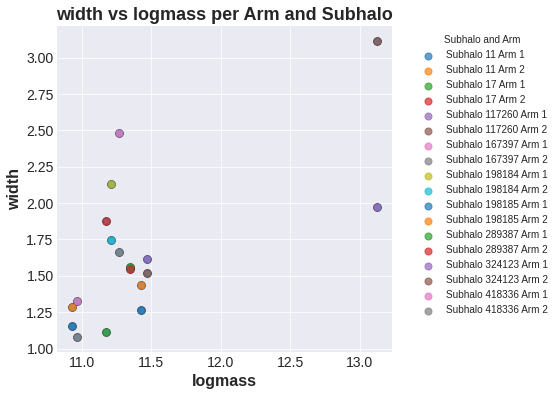

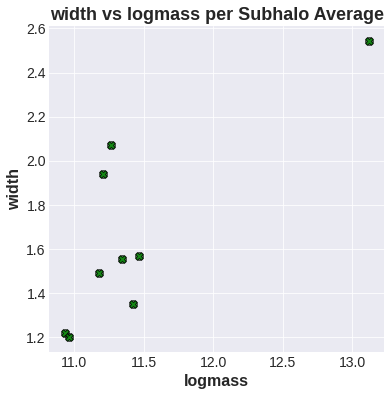

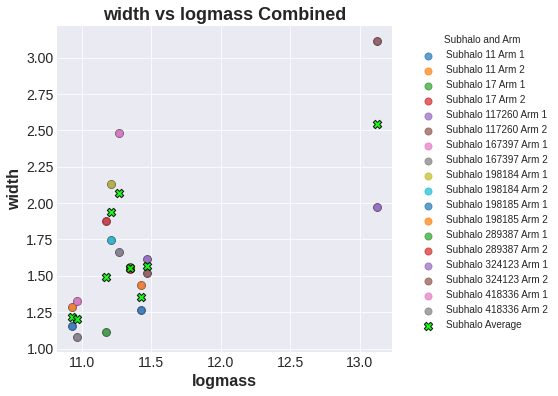

Analyzing Y_max vs logmass


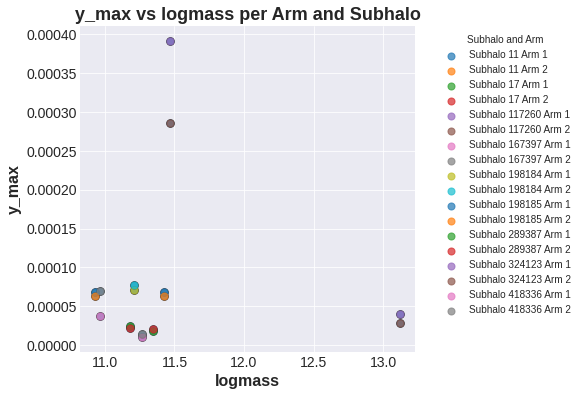

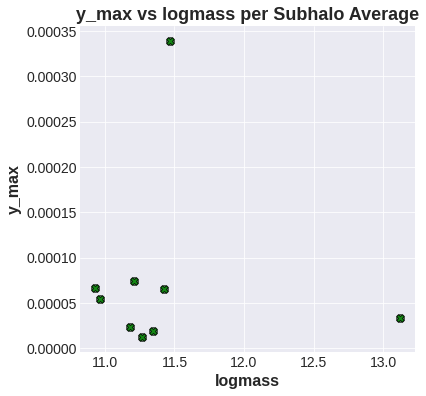

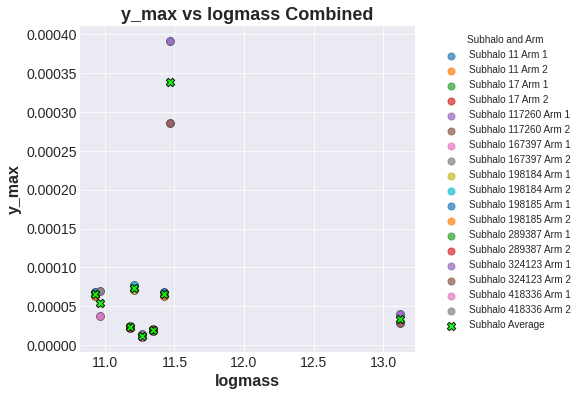

Exploring relationships for SubhaloVmaxRad...
Analyzing Width vs SubhaloVmaxRad


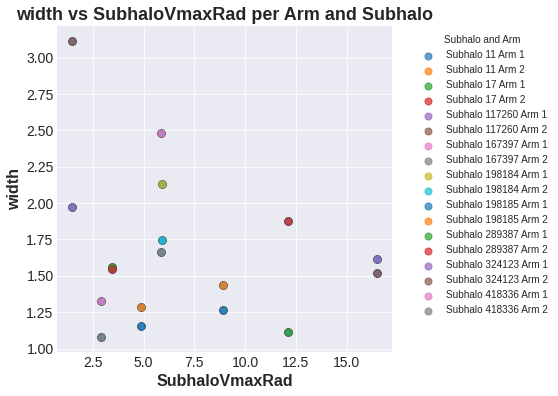

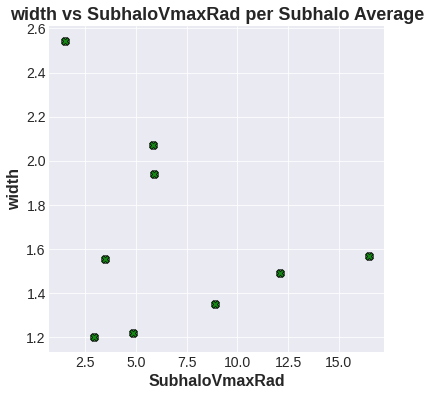

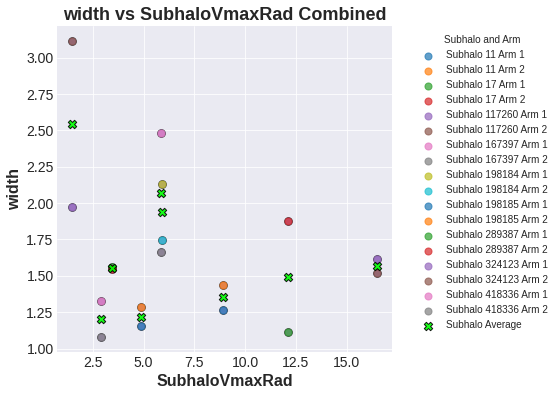

Analyzing Y_max vs SubhaloVmaxRad


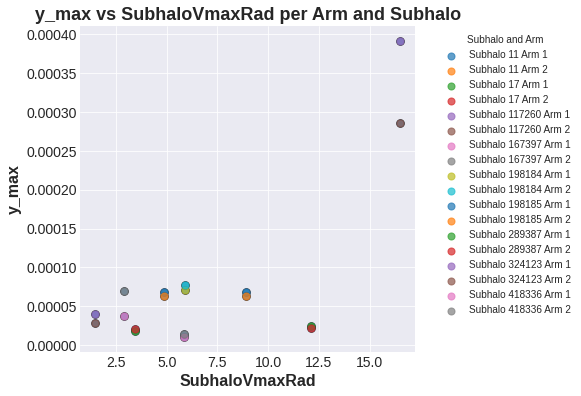

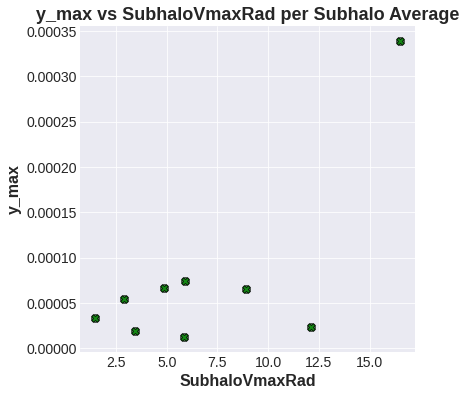

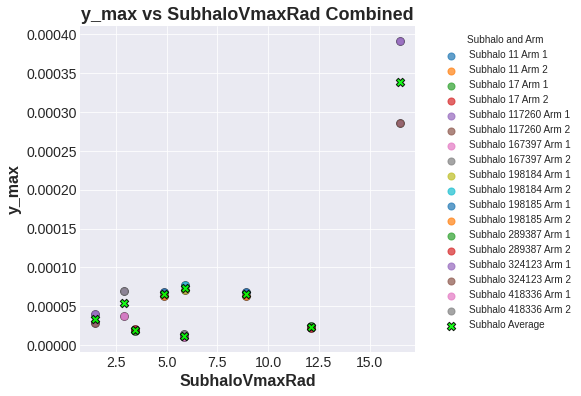

In [8]:

# Create the analysis object
analysis = GalaxyArmAnalysis(data_path, files, mass_specs_path)

# Load data and calculate merged metrics
merged_data = analysis.calculate_metrics()

# Define properties to compare (x-axis) for exploratory analysis
properties_to_compare = ['logmass', 'SubhaloVmaxRad']

# Perform and display analysis for width and y_max against selected properties
for x_property in properties_to_compare:
    print(f"Exploring relationships for {x_property}...")
    
    # Plot width vs. x_property with separate and combined views
    print(f"Analyzing Width vs {x_property}")
    plot_separate_and_combined(merged_data, 'width', x_property)
    
    # Plot y_max vs. x_property with separate and combined views
    print(f"Analyzing Y_max vs {x_property}")
    plot_separate_and_combined(merged_data, 'y_max', x_property)

In [9]:
merged_data

,halo_id,arm,width,y_max,width_error_avg,stderr_amplitude,subhalo_id,subhalo_flag,logmass,logmass0,...,SubhaloCM_x,SubhaloCM_y,SubhaloCM_z,SubhaloVel_x,SubhaloVel_y,SubhaloVel_z,SubhaloHalfmassRad,MassInMaxRad,SubhaloVmax,SubhaloVmaxRad
0,11,1,1.267312,0.000068,0.696376,0.000019,11,1,11.425411,9.980780,...,7052.748535,23818.259766,20350.101562,-538.551453,-294.423553,-505.909088,16.972178,10.899754,164.306885,8.905804
1,11,2,1.436711,0.000063,0.160012,0.000011,11,1,11.425411,9.980780,...,7052.748535,23818.259766,20350.101562,-538.551453,-294.423553,-505.909088,16.972178,10.899754,164.306885,8.905804
2,17,1,1.561147,0.000018,8.601575,0.000011,17,1,11.347348,9.895884,...,6441.108398,24251.062500,20290.275391,152.550003,323.026154,813.437622,27.491997,10.279755,129.189194,3.455755
3,17,2,1.550010,0.000021,4.866401,0.000009,17,1,11.347348,9.895884,...,6441.108398,24251.062500,20290.275391,152.550003,323.026154,813.437622,27.491997,10.279755,129.189194,3.455755
4,117260,1,1.617625,0.000392,3.985827,0.000114,117260,1,11.467149,10.559658,...,15702.835938,29237.076172,25753.494141,610.639404,436.733826,226.808884,19.294781,11.101299,152.301956,16.486126
5,117260,2,1.516644,0.000287,0.132947,0.000091,117260,1,11.467149,10.559658,...,15702.835938,29237.076172,25753.494141,610.639404,436.733826,226.808884,19.294781,11.101299,152.301956,16.486126
6,167397,1,2.478796,0.000010,2.475840,0.000007,167397,1,11.268629,10.081896,...,17110.121094,34343.101562,29091.748047,-284.108490,132.198517,25.830404,9.421091,10.788233,178.426605,5.841799
7,167397,2,1.664204,0.000014,0.022148,0.000002,167397,1,11.268629,10.081896,...,17110.121094,34343.101562,29091.748047,-284.108490,132.198517,25.830404,9.421091,10.788233,178.426605,5.841799
8,198184,1,2.128700,0.000071,0.946251,0.000014,198184,1,11.208364,10.215247,...,32130.263672,30113.146484,12603.251953,-226.769150,36.144653,-481.779358,15.890701,10.551268,134.937241,5.918883
9,198184,2,1.748079,0.000077,0.912087,0.000011,198184,1,11.208364,10.215247,...,32130.263672,30113.146484,12603.251953,-226.769150,36.144653,-481.779358,15.890701,10.551268,134.937241,5.918883


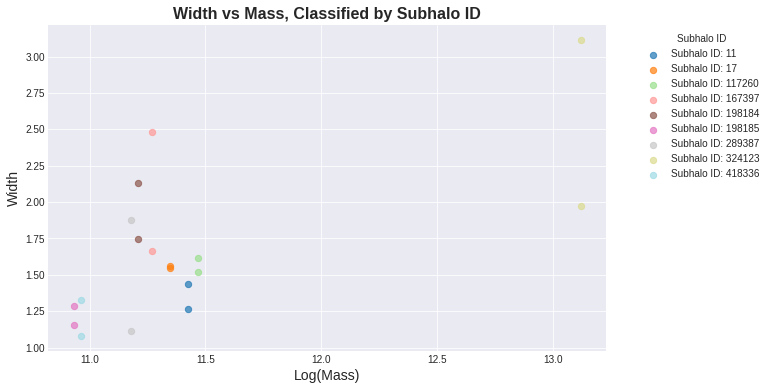

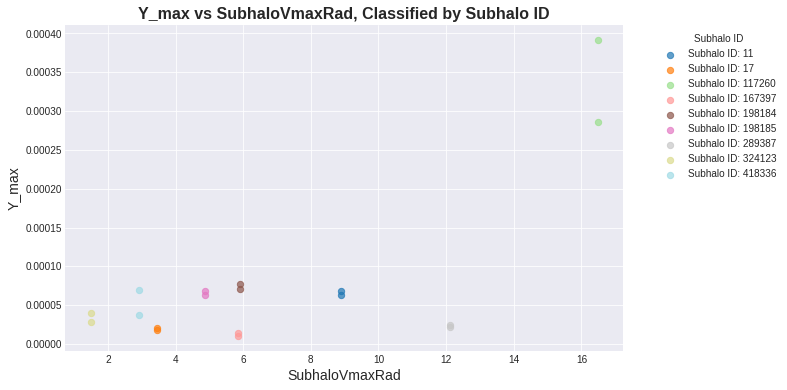

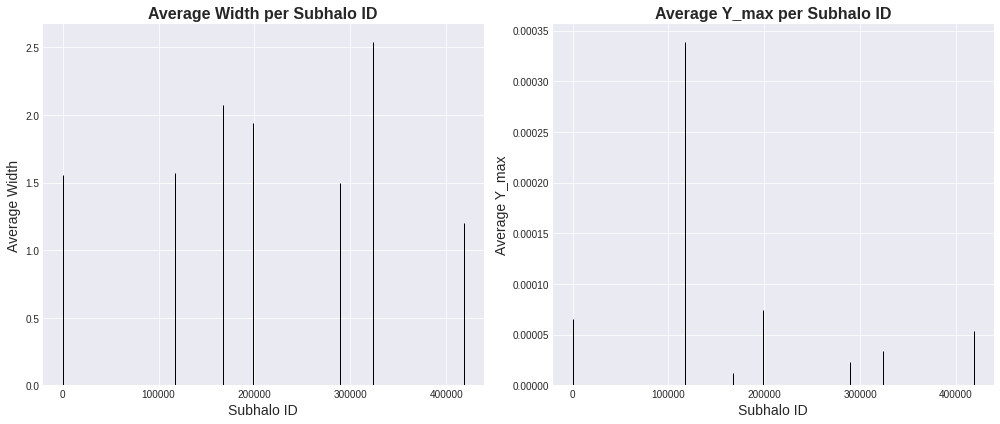

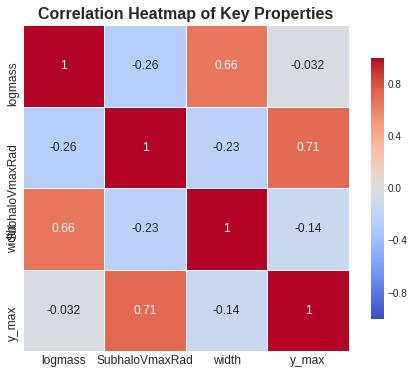

In [10]:
# Add 'halo_id' to the correlation data subset
correlation_data = merged_data[['halo_id', 'logmass','logmass0', 
                                'logmass1', 'logmass4' , 'SubhaloVmaxRad', 
                                'width', 'stderr_amplitude','y_max','width_error_avg' ]]

# Convert all data columns to ensure compatibility
correlation_data = correlation_data.astype({'halo_id': 'int64', 'logmass': 'float64', 
                                            'logmass0': 'float64', 'logmass1': 'float64', 'logmass4': 'float64',
                                            'SubhaloVmaxRad': 'float64', 'width': 'float64', 'y_max': 'float64'})

# Re-run the visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Scatter Plot for Width vs Mass, Classified by Subhalo ID
plt.figure(figsize=(10, 6))
subhalo_ids = correlation_data['halo_id'].unique()
colors = plt.cm.get_cmap('tab20', len(subhalo_ids))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    plt.scatter(subset['logmass'], subset['width'], label=f'Subhalo ID: {subhalo_id}', 
                alpha=0.7, s=40, color=colors(idx))

plt.title("Width vs Mass, Classified by Subhalo ID", fontsize=16, fontweight='bold')
plt.xlabel("Log(Mass)", fontsize=14)
plt.ylabel("Width", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Step 2: Scatter Plot for Y_max vs SubhaloVmaxRad, Classified by Subhalo ID
plt.figure(figsize=(10, 6))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    plt.scatter(subset['SubhaloVmaxRad'], subset['y_max'], label=f'Subhalo ID: {subhalo_id}', 
                alpha=0.7, s=40, color=colors(idx))

plt.title("Y_max vs SubhaloVmaxRad, Classified by Subhalo ID", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Y_max", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Step 3: Bar Plot for Average Width and Y_max per Subhalo ID
avg_width = correlation_data.groupby('halo_id')['width'].mean()
avg_ymax = correlation_data.groupby('halo_id')['y_max'].mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bar Plot for Width
ax[0].bar(avg_width.index, avg_width.values, color='skyblue', edgecolor='black')
ax[0].set_title("Average Width per Subhalo ID", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Subhalo ID", fontsize=14)
ax[0].set_ylabel("Average Width", fontsize=14)

# Bar Plot for Y_max
ax[1].bar(avg_ymax.index, avg_ymax.values, color='salmon', edgecolor='black')
ax[1].set_title("Average Y_max per Subhalo ID", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Subhalo ID", fontsize=14)
ax[1].set_ylabel("Average Y_max", fontsize=14)

plt.tight_layout()
plt.show()

# Step 4: Enhanced Heatmap for Correlation Analysis
correlation_matrix = correlation_data[['logmass', 'SubhaloVmaxRad', 'width', 'y_max']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 12})
plt.title("Correlation Heatmap of Key Properties", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



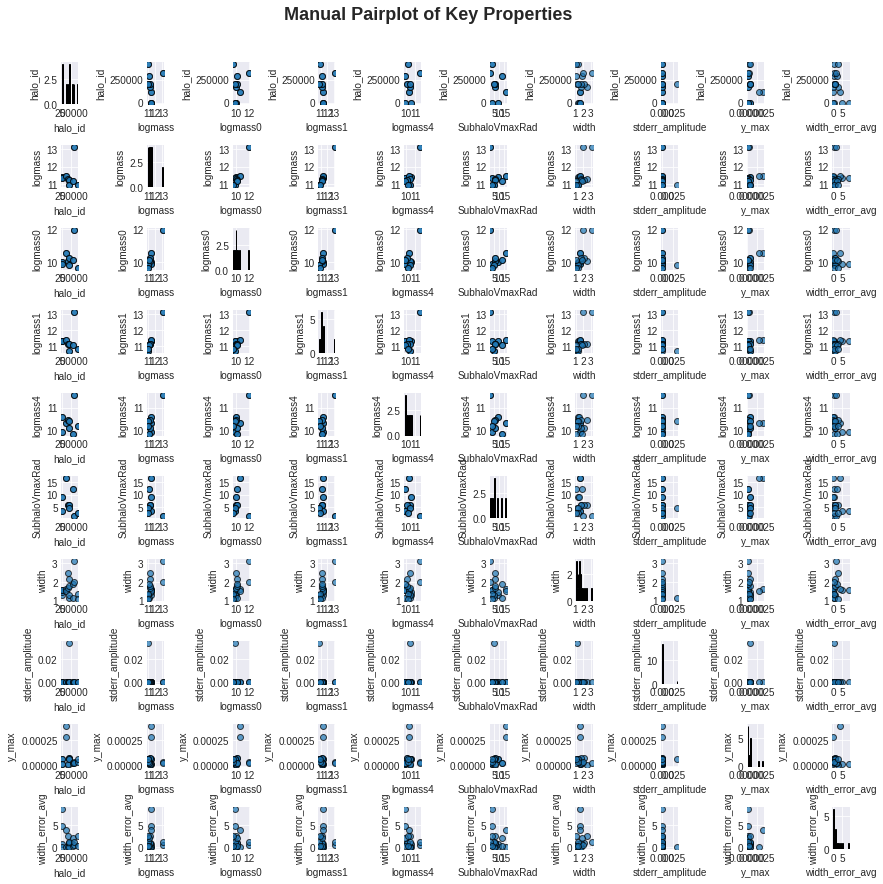

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Define pairwise plot manually for the selected data
def manual_pairplot(data):
    num_vars = data.shape[1]
    fig, axes = plt.subplots(num_vars, num_vars, figsize=(12, 12))
    fig.suptitle("Manual Pairplot of Key Properties", fontsize=18, fontweight='bold', y=1.02)

    for i in range(num_vars):
        for j in range(num_vars):
            if i == j:
                # Plot histograms on the diagonal
                axes[i, j].hist(data.iloc[:, i], bins=20, color='skyblue', edgecolor='black')
                axes[i, j].set_ylabel(data.columns[i])
                axes[i, j].set_xlabel(data.columns[j])
            else:
                # Plot scatter plots for pairwise relationships
                axes[i, j].scatter(data.iloc[:, j], data.iloc[:, i], alpha=0.7, edgecolor='k')
                axes[i, j].set_ylabel(data.columns[i])
                axes[i, j].set_xlabel(data.columns[j])

    plt.tight_layout()
    plt.show()

# Call the manual pairplot function with your correlation data
manual_pairplot(correlation_data)


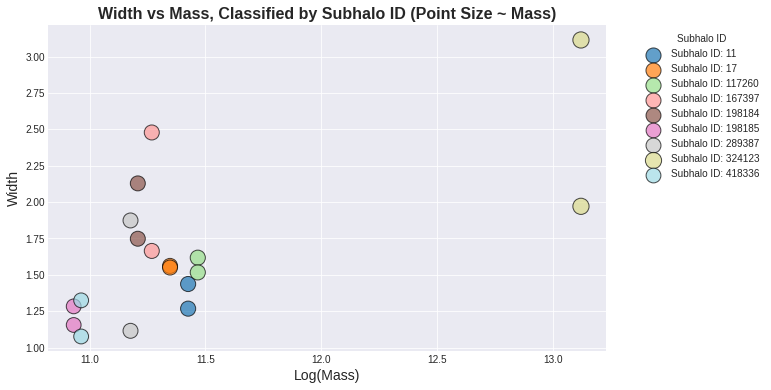

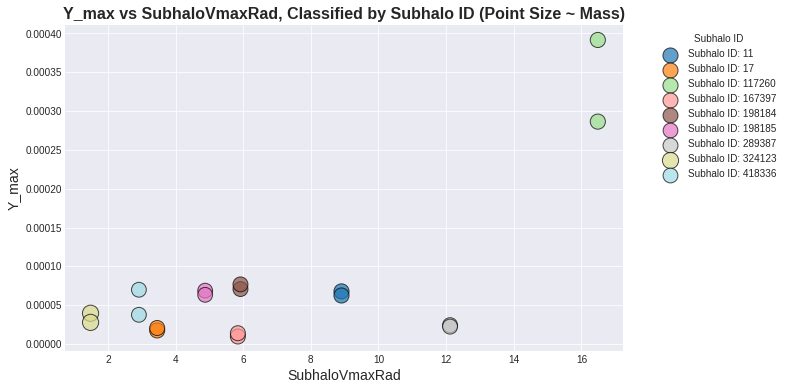

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Scatter Plot for Width vs Mass, with Point Size Indicating Mass
plt.figure(figsize=(10, 6))
subhalo_ids = correlation_data['halo_id'].unique()
colors = plt.cm.get_cmap('tab20', len(subhalo_ids))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    # Adjust point size based on 'logmass' to represent mass visually
    sizes = subset['logmass'] * 20  # Scale factor for better visualization
    plt.scatter(subset['logmass'], subset['width'], s=sizes, label=f'Subhalo ID: {subhalo_id}',
                alpha=0.7, color=colors(idx), edgecolor='k')

plt.title("Width vs Mass, Classified by Subhalo ID (Point Size ~ Mass)", fontsize=16, fontweight='bold')
plt.xlabel("Log(Mass)", fontsize=14)
plt.ylabel("Width", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Scatter Plot for Y_max vs SubhaloVmaxRad, with Point Size Indicating Mass
plt.figure(figsize=(10, 6))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    sizes = subset['logmass'] * 20  # Scale factor for mass
    plt.scatter(subset['SubhaloVmaxRad'], subset['y_max'], s=sizes, label=f'Subhalo ID: {subhalo_id}', 
                alpha=0.7, color=colors(idx), edgecolor='k')

plt.title("Y_max vs SubhaloVmaxRad, Classified by Subhalo ID (Point Size ~ Mass)", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Y_max", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


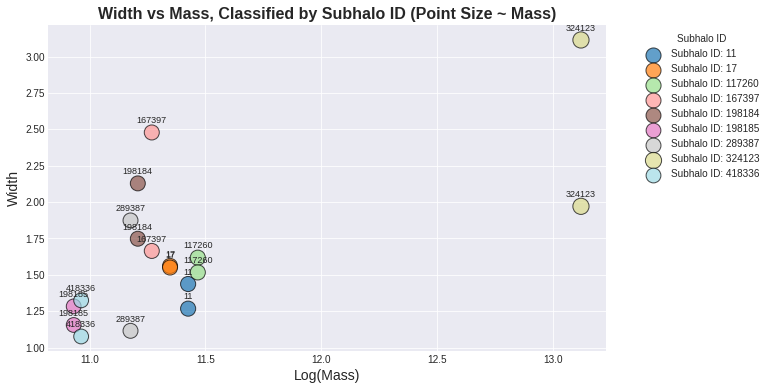

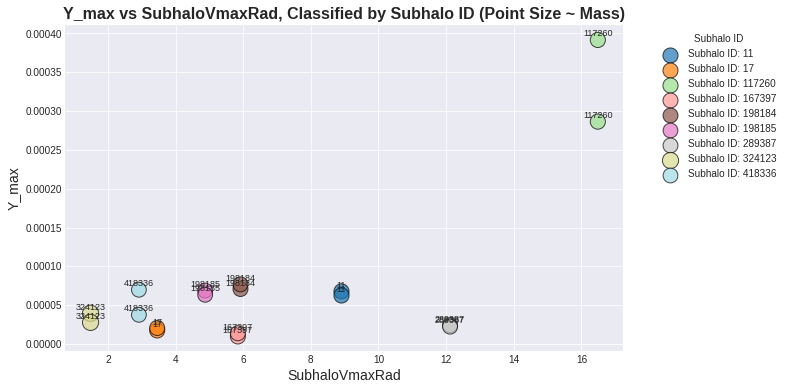

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Scatter Plot for Width vs Mass, with Point Size Indicating Mass and ID Labels
plt.figure(figsize=(10, 6))
subhalo_ids = correlation_data['halo_id'].unique()
colors = plt.cm.get_cmap('tab20', len(subhalo_ids))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    # Adjust point size based on 'logmass' to represent mass visually
    sizes = subset['logmass'] * 20  # Scale factor for better visualization
    plt.scatter(subset['logmass'], subset['width'], s=sizes, label=f'Subhalo ID: {subhalo_id}',
                alpha=0.7, color=colors(idx), edgecolor='k')
    # Add text label of subhalo_id above each point
    for i, row in subset.iterrows():
        plt.text(row['logmass'], row['width'] + 0.05, str(subhalo_id), ha='center', va='bottom', fontsize=9)

plt.title("Width vs Mass, Classified by Subhalo ID (Point Size ~ Mass)", fontsize=16, fontweight='bold')
plt.xlabel("Log(Mass)", fontsize=14)
plt.ylabel("Width", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Scatter Plot for Y_max vs SubhaloVmaxRad, with Point Size Indicating Mass and ID Labels
plt.figure(figsize=(10, 6))

for idx, subhalo_id in enumerate(subhalo_ids):
    subset = correlation_data[correlation_data['halo_id'] == subhalo_id]
    sizes = subset['logmass'] * 20  # Scale factor for mass
    plt.scatter(subset['SubhaloVmaxRad'], subset['y_max'], s=sizes, label=f'Subhalo ID: {subhalo_id}', 
                alpha=0.7, color=colors(idx), edgecolor='k')
    # Add text label of subhalo_id above each point
    for i, row in subset.iterrows():
        plt.text(row['SubhaloVmaxRad'], row['y_max'] + 0.000002, str(subhalo_id), ha='center', va='bottom', fontsize=9)

plt.title("Y_max vs SubhaloVmaxRad, Classified by Subhalo ID (Point Size ~ Mass)", fontsize=16, fontweight='bold')
plt.xlabel("SubhaloVmaxRad", fontsize=14)
plt.ylabel("Y_max", fontsize=14)
plt.legend(title="Subhalo ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


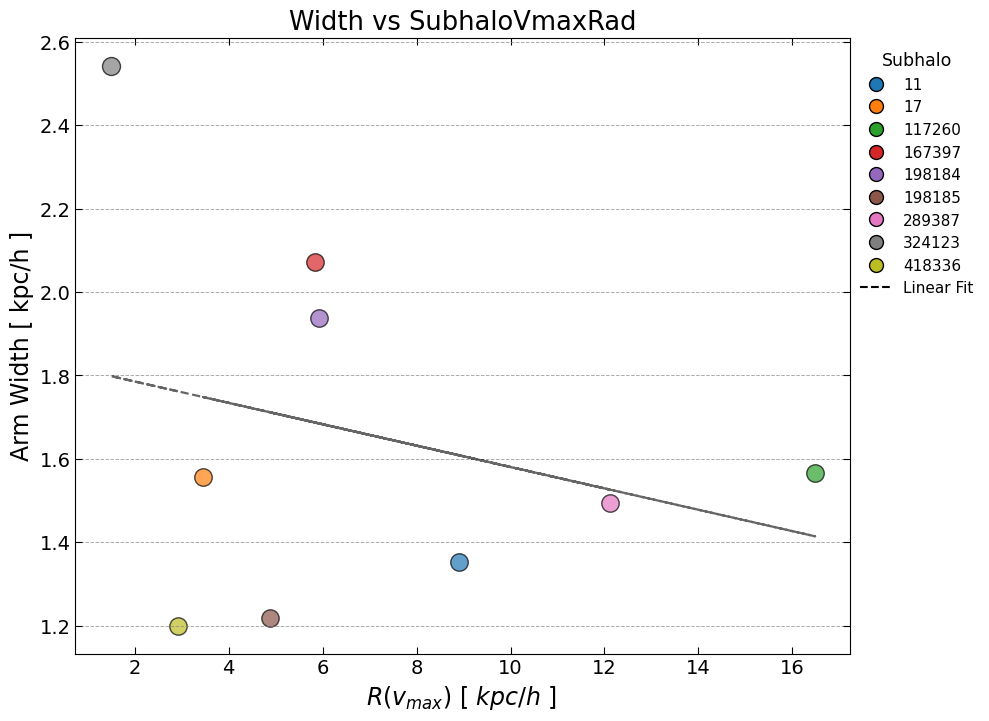

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores personalizados (azules y naranjas, evitando verdes y amarillos fosforescentes)
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
subhalo_ids = average_data['halo_id'].unique()

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Usamos el estilo predeterminado de matplotlib para simplicidad

# Gráfico: Width vs Mass (solo puntos promedio)
for idx, row in enumerate(average_data.iterrows()):
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row[1]['logmass']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row[1]['SubhaloVmaxRad'], row[1]['width'], s=size, color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Datos para el ajuste lineal
X = average_data['SubhaloVmaxRad'].values.reshape(-1, 1)
y = average_data['width'].values

# Realizar el ajuste lineal
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)

# Agregar el ajuste lineal al gráfico
plt.plot(
    average_data['SubhaloVmaxRad'], y_pred, color='black', linestyle='--', linewidth=1.6,alpha=0.6, label='Linear Fit'
)

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
plt.legend(handles=legend_elements + [Line2D([0], [0], color='black', linestyle='--', label='Linear Fit')],
           title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', title_fontsize=12.5, fontsize=11, frameon=False)

# Etiquetas del gráfico y título con tamaño adecuado
plt.title("Width vs SubhaloVmaxRad", fontsize=18.5)
plt.xlabel(r"$R(v_{max})$ [ $kpc/h$ ] ", fontsize=17)
plt.ylabel(r"Arm Width [ kpc/h ]", fontsize=17)


#plt.xlim(10.6, 13.9)
#plt.ylim(1.01, 2.78)
# Mostrar bordes y ticks en los cuatro lados
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=14, length=5)

# Configuración de ticks en los ejes x e y
#plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))       # Ticks mayores a intervalos de 1 en el eje x
#plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.5))     # Ticks menores a intervalos de 0.5 en el eje x
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))       # Ticks mayores a intervalos de 1 en el eje y
#plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))     # Ticks menores a intervalos de 0.5 en el eje y

# Configuración de la cuadrícula en los ticks mayores e intermedios de forma independiente
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)

# Asegurar que se muestren las etiquetas de los ticks menores en los ejes x e y
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))

# Mostrar gráfico
plt.show()



In [31]:
average_data

,halo_id,logmass,logmass0,logmass1,logmass4,SubhaloVmaxRad,width,stderr_amplitude,y_max,width_error_avg
0,11,11.425411,9.980780,11.343677,10.557160,8.905804,1.352011,0.000015,0.000065,0.428194
1,17,11.347348,9.895884,11.314726,9.914086,3.455755,1.555579,0.000010,0.000019,6.733988
2,117260,11.467149,10.559658,11.374504,10.301546,16.486126,1.567135,0.000102,0.000339,2.059387
3,167397,11.268629,10.081896,11.159579,10.463722,5.841799,2.071500,0.000004,0.000012,1.248994
4,198184,11.208364,10.215247,11.124784,10.073717,5.918883,1.938390,0.000013,0.000074,0.929169
5,198185,10.931653,9.806524,10.731865,10.398789,4.874750,1.218958,0.017075,0.000066,0.682182
6,289387,11.176843,10.143049,11.112185,9.836786,12.115808,1.494297,0.000004,0.000023,1.252393
7,324123,13.120424,11.968402,13.075736,11.555799,1.485894,2.542970,0.000009,0.000034,0.910571
8,418336,10.963822,9.626917,10.863265,10.168530,2.915534,1.200102,0.000009,0.000054,1.476434


In [15]:
average_data

,halo_id,logmass,logmass0,logmass1,logmass4,SubhaloVmaxRad,width,stderr_amplitude,y_max,width_error_avg
0,11,11.425411,9.980780,11.343677,10.557160,8.905804,1.352011,0.000015,0.000065,0.428194
1,17,11.347348,9.895884,11.314726,9.914086,3.455755,1.555579,0.000010,0.000019,6.733988
2,117260,11.467149,10.559658,11.374504,10.301546,16.486126,1.567135,0.000102,0.000339,2.059387
3,167397,11.268629,10.081896,11.159579,10.463722,5.841799,2.071500,0.000004,0.000012,1.248994
4,198184,11.208364,10.215247,11.124784,10.073717,5.918883,1.938390,0.000013,0.000074,0.929169
5,198185,10.931653,9.806524,10.731865,10.398789,4.874750,1.218958,0.017075,0.000066,0.682182
6,289387,11.176843,10.143049,11.112185,9.836786,12.115808,1.494297,0.000004,0.000023,1.252393
7,324123,13.120424,11.968402,13.075736,11.555799,1.485894,2.542970,0.000009,0.000034,0.910571
8,418336,10.963822,9.626917,10.863265,10.168530,2.915534,1.200102,0.000009,0.000054,1.476434


In [16]:
for idx, row in enumerate(average_data.iterrows()):
    print('idx:',idx)
    print('row:',row[1]['logmass0'])

idx: 0
row: 9.980780000000001
idx: 1
row: 9.895883999999999
idx: 2
row: 10.559658
idx: 3
row: 10.081896
idx: 4
row: 10.215247
idx: 5
row: 9.806524000000001
idx: 6
row: 10.143049000000001
idx: 7
row: 11.968402000000001
idx: 8
row: 9.626917


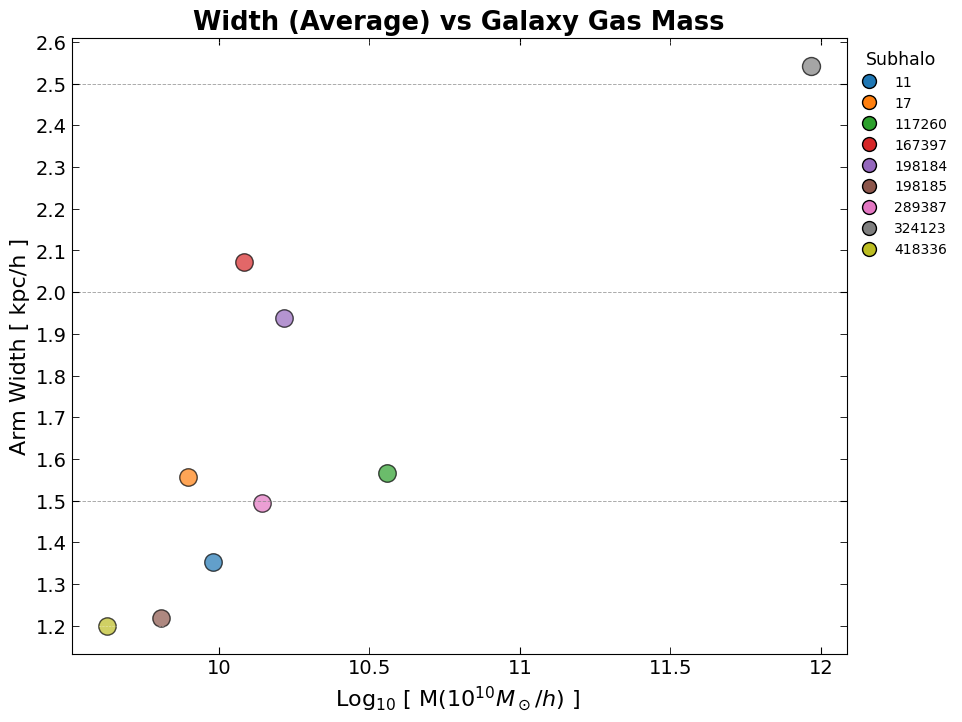

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores personalizados (azules y naranjas, evitando verdes y amarillos fosforescentes)
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
subhalo_ids = average_data['halo_id'].unique()

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Usamos el estilo predeterminado de matplotlib para simplicidad

# Gráfico: Width vs Mass (solo puntos promedio)
for idx, row in enumerate(average_data.iterrows()):
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row[1]['logmass']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row[1]['logmass0'], row[1]['width'], s=size, color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas del gráfico y título con tamaño adecuado
plt.title("Width (Average) vs Galaxy Gas Mass", fontsize=18.5, weight='bold')
plt.xlabel(r"Log$_{10}$ [ M($10^{10} M_\odot/h) $ ] ", fontsize=16)
plt.ylabel(r"Arm Width [ kpc/h ]", fontsize=16)
#plt.xlim(10.6, 13.9)
#plt.ylim(1.01,2.78)
# Mostrar bordes y ticks en los cuatro lados
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=14, length=5)

# Configuración de ticks en los ejes x e y
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))       # Ticks mayores a intervalos de 1 en el eje x
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.5))     # Ticks menores a intervalos de 0.5 en el eje x
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))       # Ticks mayores a intervalos de 1 en el eje y
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))     # Ticks menores a intervalos de 0.5 en el eje y

# Configuración de la cuadrícula en los ticks mayores e intermedios de forma independiente
# Cuadrícula en ticks mayores (11, 12, 13, ...) con un color específico
#plt.gca().xaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.78, alpha=0.78)
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)

# Cuadrícula en ticks menores (11.5, 12.5, ...) con otro color y estilo
#plt.gca().xaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.55, alpha=0.55)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)

# Asegurar que se muestren las etiquetas de los ticks menores en los ejes x e y
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))

# Mostrar gráfico
plt.show()


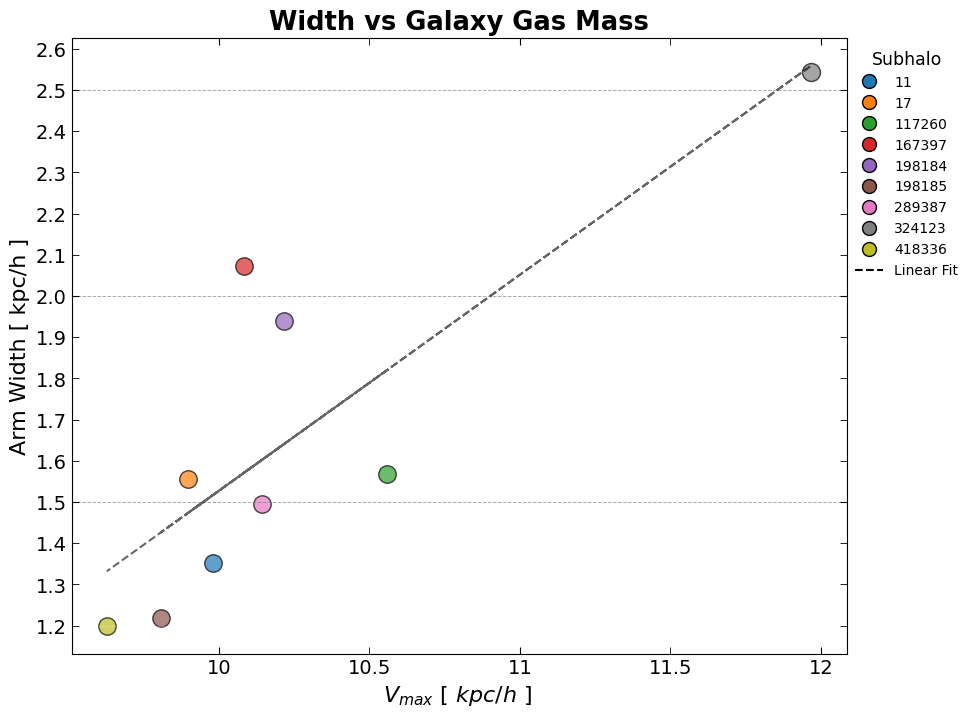

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores personalizados (azules y naranjas, evitando verdes y amarillos fosforescentes)
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
subhalo_ids = average_data['halo_id'].unique()

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Usamos el estilo predeterminado de matplotlib para simplicidad

# Gráfico: Width vs Mass (solo puntos promedio)
for idx, row in enumerate(average_data.iterrows()):
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row[1]['logmass']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row[1]['logmass0'], row[1]['width'], s=size, color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Datos para el ajuste lineal
X = average_data['logmass0'].values.reshape(-1, 1)
y = average_data['width'].values

# Realizar el ajuste lineal
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)

# Agregar el ajuste lineal al gráfico
plt.plot(
    average_data['logmass0'], y_pred, color='black', linestyle='--', linewidth=1.5, alpha= 0.6,label='Ajuste Lineal'
)

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
plt.legend(handles=legend_elements + [Line2D([0], [0], color='black', linestyle='--', label='Linear Fit')],
           title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas del gráfico y título con tamaño adecuado
plt.title("Width vs Galaxy Gas Mass", fontsize=18.5, weight='bold')
plt.xlabel(r"$V_{max}$ [ $kpc/h$ ] ", fontsize=16)
plt.ylabel(r"Arm Width [ kpc/h ]", fontsize=16)

# Etiquetas y título
plt.title(r"$A(\rho)_{max}$ vs SubhaloVmaxRad", fontsize=18.5)
plt.xlabel(r"$R(v_{max})$ [ $kpc/h$ ] ", fontsize=17)
plt.ylabel(r"$\log_{10} [A(\rho)_{max}][ M_\odot kpc^{-3} ]$", fontsize=17)


#plt.xlim(10.6, 13.9)
#plt.ylim(1.01,2.78)
# Mostrar bordes y ticks en los cuatro lados
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=14, length=5)

# Configuración de ticks en los ejes x e y
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))       # Ticks mayores a intervalos de 1 en el eje x
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.5))     # Ticks menores a intervalos de 0.5 en el eje x
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))       # Ticks mayores a intervalos de 1 en el eje y
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))     # Ticks menores a intervalos de 0.5 en el eje y

# Configuración de la cuadrícula en los ticks mayores e intermedios de forma independiente
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)

# Asegurar que se muestren las etiquetas de los ticks menores en los ejes x e y
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))

# Mostrar gráfico
plt.show()


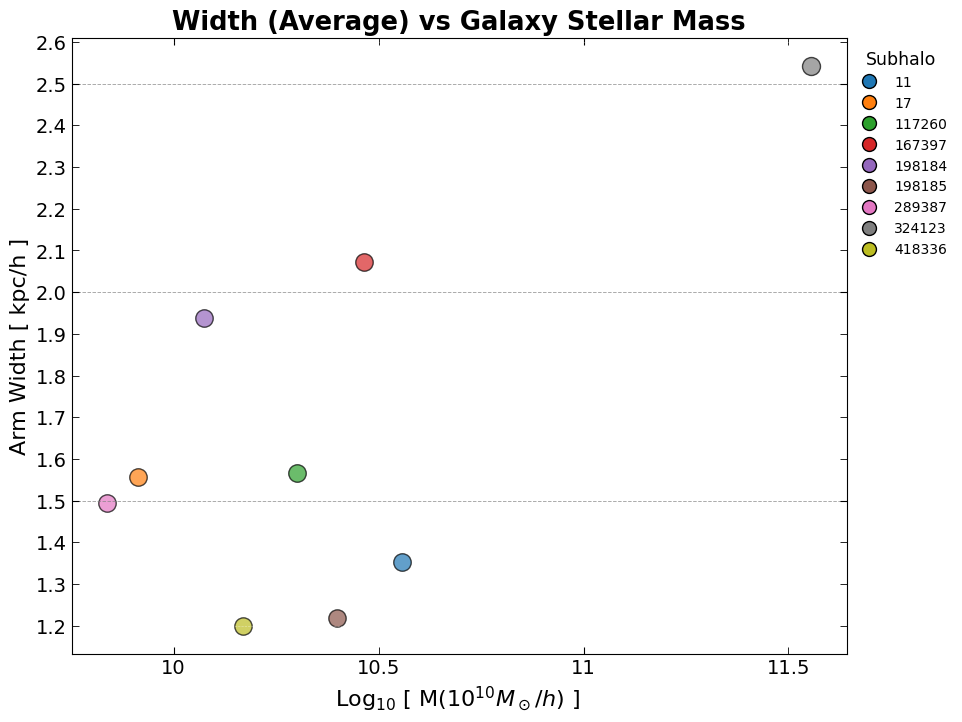

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores personalizados (azules y naranjas, evitando verdes y amarillos fosforescentes)
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
subhalo_ids = average_data['halo_id'].unique()

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Usamos el estilo predeterminado de matplotlib para simplicidad

# Gráfico: Width vs Mass (solo puntos promedio)
for idx, row in enumerate(average_data.iterrows()):
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row[1]['logmass']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row[1]['logmass4'], row[1]['width'], s=size, color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas del gráfico y título con tamaño adecuado
plt.title("Width (Average) vs Galaxy Stellar Mass", fontsize=18.5, weight='bold')
plt.xlabel(r"Log$_{10}$ [ M($10^{10} M_\odot/h) $ ] ", fontsize=16)
plt.ylabel(r"Arm Width [ kpc/h ]", fontsize=16)
#plt.xlim(10.6, 13.9)
#plt.ylim(1.01,2.78)
# Mostrar bordes y ticks en los cuatro lados
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=14, length=5)

# Configuración de ticks en los ejes x e y
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))       # Ticks mayores a intervalos de 1 en el eje x
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.5))     # Ticks menores a intervalos de 0.5 en el eje x
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))       # Ticks mayores a intervalos de 1 en el eje y
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))     # Ticks menores a intervalos de 0.5 en el eje y

# Configuración de la cuadrícula en los ticks mayores e intermedios de forma independiente
# Cuadrícula en ticks mayores (11, 12, 13, ...) con un color específico
#plt.gca().xaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.78, alpha=0.78)
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)

# Cuadrícula en ticks menores (11.5, 12.5, ...) con otro color y estilo
#plt.gca().xaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.55, alpha=0.55)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)

# Asegurar que se muestren las etiquetas de los ticks menores en los ejes x e y
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))

# Mostrar gráfico
plt.show()

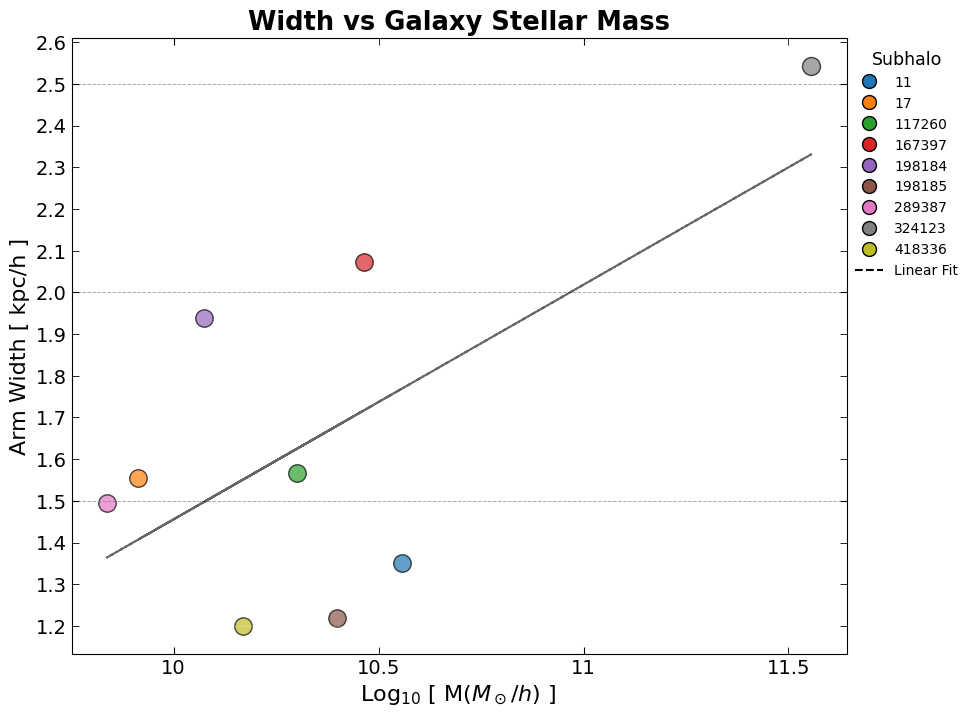

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores personalizados (azules y naranjas, evitando verdes y amarillos fosforescentes)
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
subhalo_ids = average_data['halo_id'].unique()

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Usamos el estilo predeterminado de matplotlib para simplicidad

# Gráfico: Width vs Mass (solo puntos promedio)
for idx, row in enumerate(average_data.iterrows()):
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row[1]['logmass']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row[1]['logmass4'], row[1]['width'], s=size, color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Ajuste lineal
X = average_data['logmass4'].values.reshape(-1, 1)  # Eje x: logmass4
y = average_data['width'].values                   # Eje y: width

# Crear el modelo lineal y ajustar
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)

# Agregar el ajuste lineal al gráfico
plt.plot(average_data['logmass4'], y_pred, color='black', linestyle='--', linewidth=1.5, alpha=0.6,label='Ajuste Lineal')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
plt.legend(handles=legend_elements + [Line2D([0], [0], color='black', linestyle='--', label='Linear Fit')],
           title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas del gráfico y título con tamaño adecuado
plt.title("Width vs Galaxy Stellar Mass", fontsize=18.5, weight='bold')
plt.xlabel(r"Log$_{10}$ [ M($M_\odot/h) $ ] ", fontsize=16)
plt.ylabel(r"Arm Width [ kpc/h ]", fontsize=16)
#plt.xlim(10.6, 13.9)
#plt.ylim(1.01, 2.78)

# Mostrar bordes y ticks en los cuatro lados
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=14, length=5)

# Configuración de ticks en los ejes x e y
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))       # Ticks mayores a intervalos de 1 en el eje x
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.5))     # Ticks menores a intervalos de 0.5 en el eje x
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))       # Ticks mayores a intervalos de 1 en el eje y
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.1))     # Ticks menores a intervalos de 0.5 en el eje y

# Configuración de la cuadrícula en los ticks mayores e intermedios de forma independiente
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)

# Asegurar que se muestren las etiquetas de los ticks menores en los ejes x e y
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
plt.gca().yaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))

# Mostrar gráfico
plt.show()


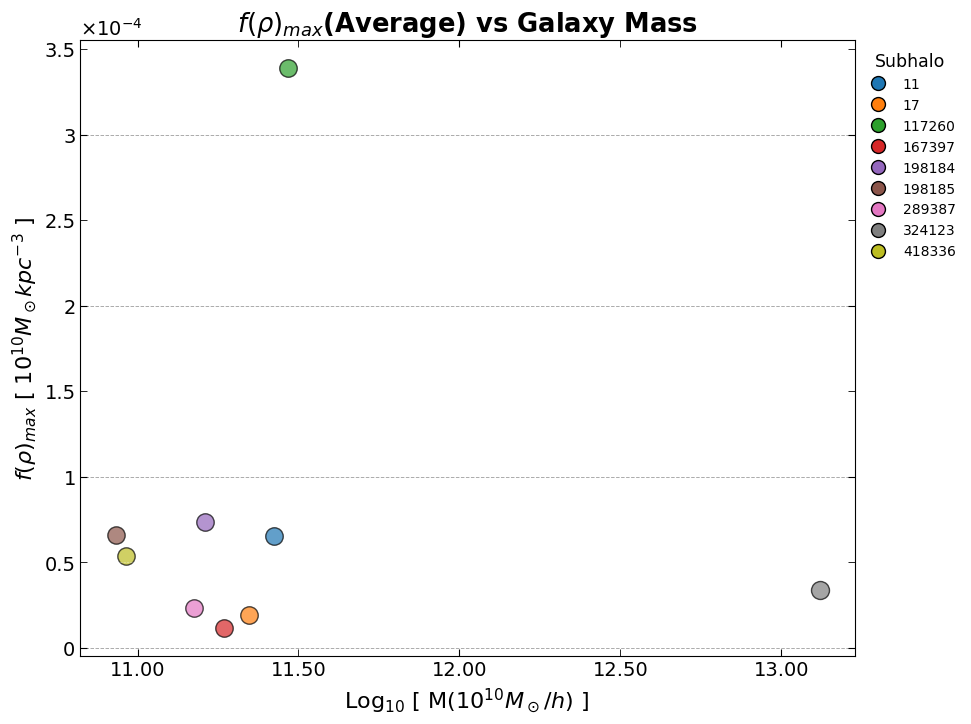

In [21]:

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Usamos el estilo predeterminado de matplotlib para simplicidad
def divide_by_minus_4(x, pos):
    return f"{x * 1e4:.1f}"  # Multiplica por 10^4 y convierte a entero

# Gráfico: Width vs Mass (solo puntos promedio)
for idx, row in enumerate(average_data.iterrows()):
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row[1]['logmass']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row[1]['logmass'], row[1]['y_max'], s=size, color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas del gráfico y título con tamaño adecuado
plt.title(r"$f(\rho)_{max}$(Average) vs Galaxy Mass", fontsize=18.5, weight='bold')
plt.xlabel(r"Log$_{10}$ [ M($10^{10} M_\odot/h) $ ] ", fontsize=16)
plt.ylabel(r"$f(\rho)_{max}$ [ $10^{10} M_\odot kpc^{-3}$ ]", fontsize=16)
#plt.xlim(10.6, 13.9)
#plt.ylim(1.01,2.78)
# Mostrar bordes y ticks en los cuatro lados
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=14, length=5)

# Configuración de ticks en los ejes x e y
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.0))       # Ticks mayores a intervalos de 1 en el eje x
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.5))     # Ticks menores a intervalos de 0.5 en el eje x
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))       # Ticks mayores a intervalos de 1 en el eje y
#plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.0001))     # Ticks menores a intervalos de 0.5 en el eje y

# Configuración de la cuadrícula en los ticks mayores e intermedios de forma independiente
# Cuadrícula en ticks mayores (11, 12, 13, ...) con un color específico
#plt.gca().xaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.78, alpha=0.78)
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)

# Cuadrícula en ticks menores (11.5, 12.5, ...) con otro color y estilo
#plt.gca().xaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.55, alpha=0.55)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)

# Asegurar que se muestren las etiquetas de los ticks menores en los ejes x e y
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

plt.gca().yaxis.set_minor_formatter(ticker.FuncFormatter(divide_by_minus_4))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

# Configuración del eje Y con notación científica
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0001))  # Ticks mayores en el eje Y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.00005))  # Ticks menores en el eje Y
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))  # Formato científico
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))  # Forzar notación científica en el eje Y
ax.yaxis.get_offset_text().set_fontsize(14)  # Ajustar tamaño de la notación científica


# Mostrar gráfico
plt.show()

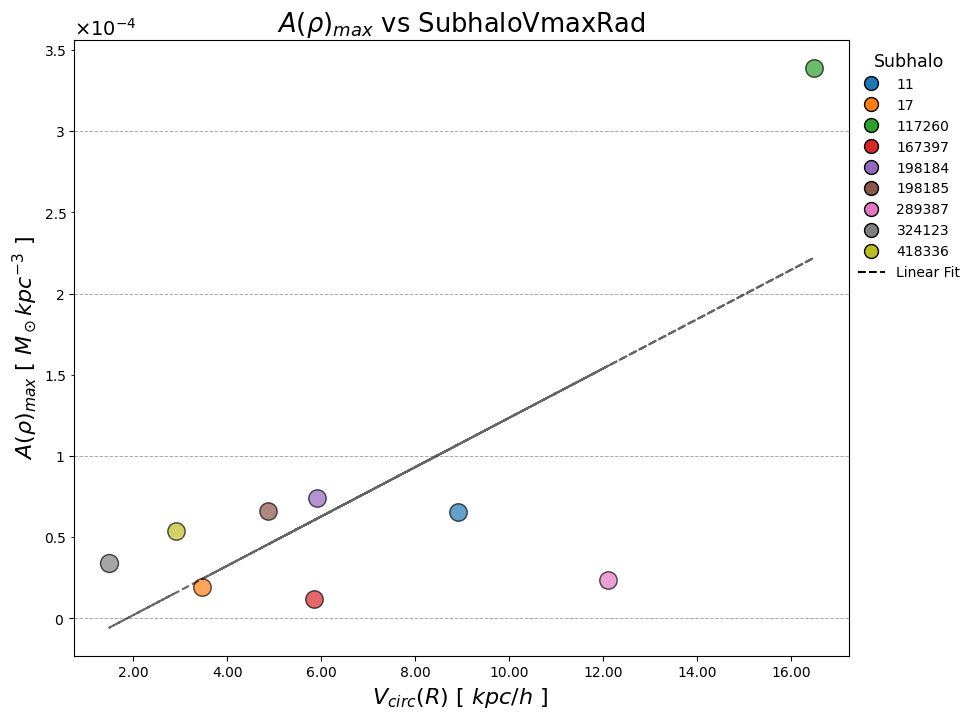

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# Calcular los promedios para cada subhalo
average_data = correlation_data.groupby('halo_id').mean().reset_index()

# Colores personalizados (azules y naranjas, evitando verdes y amarillos fosforescentes)
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
subhalo_ids = average_data['halo_id'].unique()

# Extraer datos para el ajuste lineal
X = average_data['SubhaloVmaxRad'].values.reshape(-1, 1)  # Reshape para sklearn
y = average_data['y_max'].values

# Crear el modelo lineal y ajustar
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Usamos el estilo predeterminado de matplotlib para simplicidad

def divide_by_minus_4(x, pos):
    return f"{x * 1e4:.1f}"  # Multiplica por 10^4 y convierte a decimal con 1 cifra

# Gráfico: Width vs Mass (solo puntos promedio)
for idx, row in enumerate(average_data.iterrows()):
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row[1]['logmass']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row[1]['SubhaloVmaxRad'], row[1]['y_max'], s=size, color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Graficar la línea de ajuste lineal
plt.plot(average_data['SubhaloVmaxRad'], y_pred, color='black', linestyle='--', linewidth=1.5, alpha=0.6,  label='Linear Fit')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
legend_elements.append(Line2D([0], [0], color='black', linestyle='--', label='Linear Fit'))  # Agregar línea de ajuste a la leyenda
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas del gráfico y título con tamaño adecuado
plt.title(r"$A(\rho)_{max}$ vs SubhaloVmaxRad", fontsize=18.5)
plt.xlabel(r"$V_{circ}(R)$ [ $kpc/h$ ] ", fontsize=16)
plt.ylabel(r"$A(\rho)_{max}$ [ $ M_\odot kpc^{-3}$ ]", fontsize=16)

# Configuración de ticks en los ejes x e y
# Configuración de la cuadrícula en los ticks mayores e intermedios de forma independiente
# Cuadrícula en ticks mayores (11, 12, 13, ...) con un color específico
#plt.gca().xaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.78, alpha=0.78)
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)

# Cuadrícula en ticks menores (11.5, 12.5, ...) con otro color y estilo
#plt.gca().xaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.55, alpha=0.55)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)

# Asegurar que se muestren las etiquetas de los ticks menores en los ejes x e y
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

plt.gca().yaxis.set_minor_formatter(ticker.FuncFormatter(divide_by_minus_4))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

# Configuración del eje Y con notación científica
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0001))  # Ticks mayores en el eje Y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.00005))  # Ticks menores en el eje Y
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))  # Formato científico
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))  # Forzar notación científica en el eje Y
ax.yaxis.get_offset_text().set_fontsize(14)  # Ajustar tamaño de la notación científica


# Mostrar gráfico
plt.show()




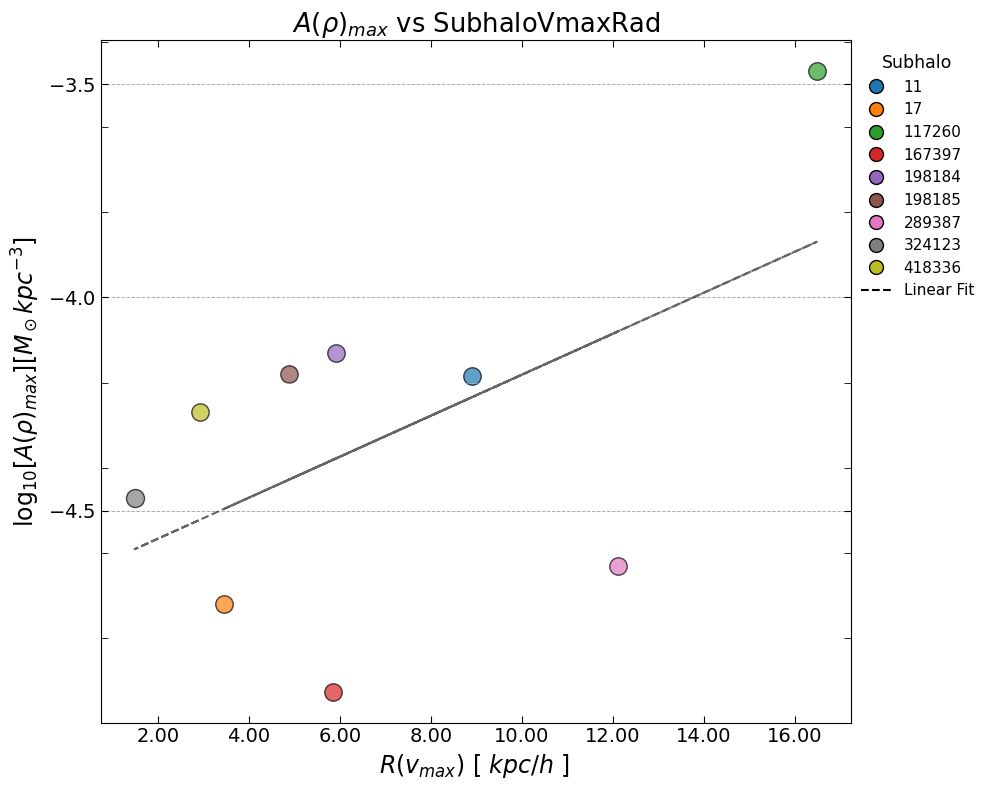

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# Calcular los promedios para cada subhalo y transformar y_max a log10
average_data = correlation_data.groupby('halo_id').mean().reset_index()
average_data['log_y_max'] = np.log10(average_data['y_max'])

# Colores personalizados
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
subhalo_ids = average_data['halo_id'].unique()

# Extraer datos para el ajuste lineal
X = average_data['SubhaloVmaxRad'].values.reshape(-1, 1)  # Eje x: SubhaloVmaxRad
y = average_data['log_y_max'].values  # Eje y transformado a log10

# Crear el modelo lineal y ajustar
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Estilo predeterminado de matplotlib

# Función para dividir por 10^-4 en las etiquetas
def divide_by_minus_4(x, pos):
    return f"{x * 1e4:.1f}"  # Multiplica por 10^4 y convierte a decimal con 1 cifra

# Gráfico de dispersión
for idx, row in enumerate(average_data.iterrows()):
    size = np.log10(row[1]['logmass']) * 150  # Escala de tamaño basada en logmass
    plt.scatter(row[1]['SubhaloVmaxRad'], row[1]['log_y_max'], s=size,
                color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Graficar la línea de ajuste lineal
plt.plot(average_data['SubhaloVmaxRad'], y_pred, color='black', linestyle='--', linewidth=1.5, alpha=0.6, label='Linear Fit')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
legend_elements.append(Line2D([0], [0], color='black', linestyle='--', label='Linear Fit'))  # Agregar línea de ajuste
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=11, frameon=False)

# Etiquetas y título
plt.title(r"$A(\rho)_{max}$ vs SubhaloVmaxRad", fontsize=18.5)
plt.xlabel(r"$R(v_{max})$ [ $kpc/h$ ] ", fontsize=17)
plt.ylabel(r"$\log_{10} [A(\rho)_{max}][ M_\odot kpc^{-3} ]$", fontsize=17)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=14, length=5)

# Configuración de ticks en los ejes
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Configuración de cuadrícula y ticks en el eje y
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))

# Ajustar diseño y mostrar gráfico
plt.tight_layout()
plt.show()


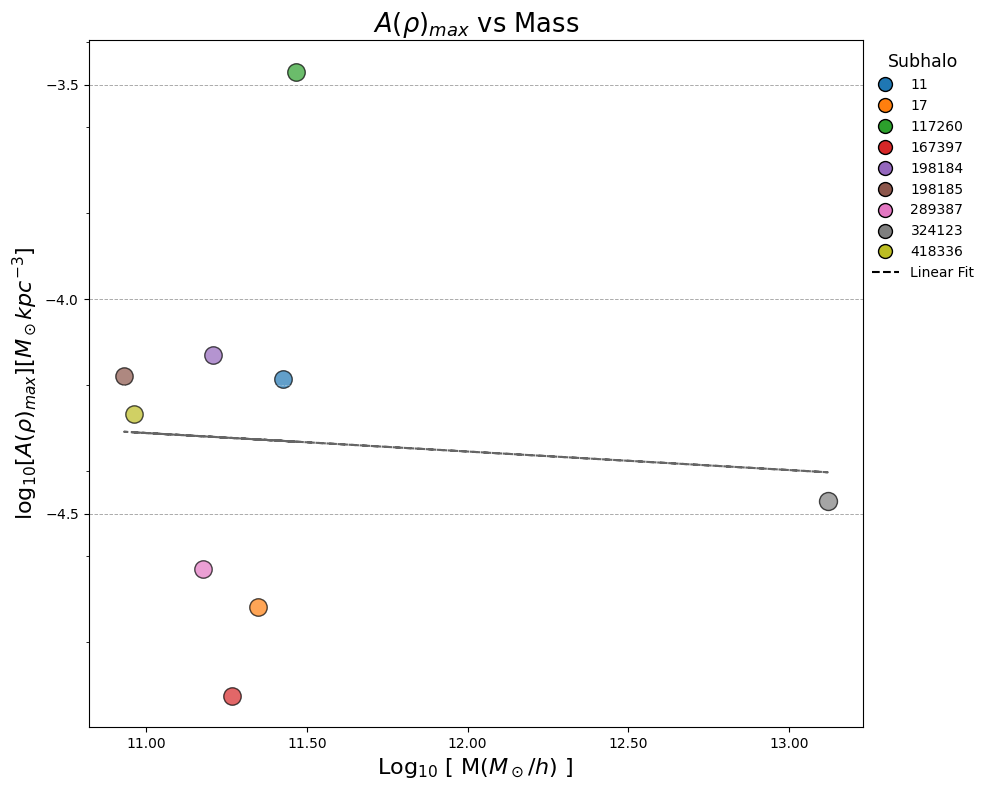

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# Calcular los promedios para cada subhalo y transformar y_max a log10
average_data = correlation_data.groupby('halo_id').mean().reset_index()
average_data['log_y_max'] = np.log10(average_data['y_max'])  # Transformar amplitud a log10

# Colores personalizados
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
subhalo_ids = average_data['halo_id'].unique()

# Datos para el ajuste lineal (eje x: logmass0, eje y: log_y_max)
X = average_data['logmass'].values.reshape(-1, 1)  # Masa de gas en log10
y = average_data['log_y_max'].values  # Amplitud en log10

# Crear el modelo lineal y ajustar
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Estilo predeterminado de matplotlib

# Gráfico de dispersión
for idx, row in enumerate(average_data.iterrows()):
    size = np.log10(row[1]['logmass']) * 150  # Escala de tamaño basada en logmass
    plt.scatter(row[1]['logmass'], row[1]['log_y_max'], s=size,
                color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Graficar la línea de ajuste lineal
plt.plot(average_data['logmass'], y_pred, color='black', linestyle='--', linewidth=1.5, alpha=0.6, label='Linear Fit')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
legend_elements.append(Line2D([0], [0], color='black', linestyle='--', label='Linear Fit'))  # Agregar línea de ajuste
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas y título
plt.title(r"$A(\rho)_{max}$ vs Mass", fontsize=18.5)
plt.xlabel(r"Log$_{10}$ [ M($M_\odot/h) $ ] ", fontsize=16)
plt.ylabel(r"$\log_{10} [A(\rho)_{max}][ M_\odot kpc^{-3} ]$", fontsize=16)

# Configuración de ticks en los ejes
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Configuración de cuadrícula y ticks en el eje y
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))

# Ajustar diseño y mostrar gráfico
plt.tight_layout()
plt.show()


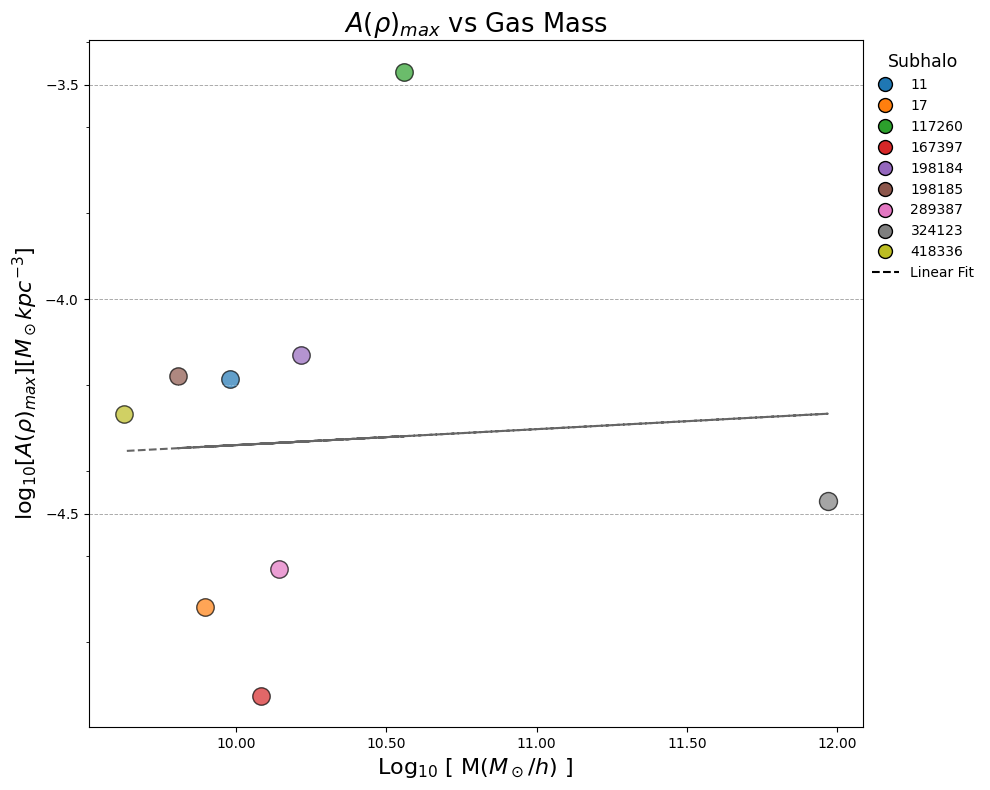

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# Calcular los promedios para cada subhalo y transformar y_max a log10
average_data = correlation_data.groupby('halo_id').mean().reset_index()
average_data['log_y_max'] = np.log10(average_data['y_max'])  # Transformar amplitud a log10

# Colores personalizados
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
subhalo_ids = average_data['halo_id'].unique()

# Datos para el ajuste lineal (eje x: logmass0, eje y: log_y_max)
X = average_data['logmass0'].values.reshape(-1, 1)  # Masa de gas en log10
y = average_data['log_y_max'].values  # Amplitud en log10

# Crear el modelo lineal y ajustar
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Estilo predeterminado de matplotlib

# Gráfico de dispersión
for idx, row in enumerate(average_data.iterrows()):
    size = np.log10(row[1]['logmass']) * 150  # Escala de tamaño basada en logmass
    plt.scatter(row[1]['logmass0'], row[1]['log_y_max'], s=size,
                color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Graficar la línea de ajuste lineal
plt.plot(average_data['logmass0'], y_pred, color='black', linestyle='--', linewidth=1.5, alpha=0.6, label='Linear Fit')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
legend_elements.append(Line2D([0], [0], color='black', linestyle='--', label='Linear Fit'))  # Agregar línea de ajuste
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas y título
plt.title(r"$A(\rho)_{max}$ vs Gas Mass", fontsize=18.5)
plt.xlabel(r"Log$_{10}$ [ M($M_\odot/h) $ ] ", fontsize=16)
plt.ylabel(r"$\log_{10} [A(\rho)_{max}][ M_\odot kpc^{-3} ]$", fontsize=16)

# Configuración de ticks en los ejes
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Configuración de cuadrícula y ticks en el eje y
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))

# Ajustar diseño y mostrar gráfico
plt.tight_layout()
plt.show()


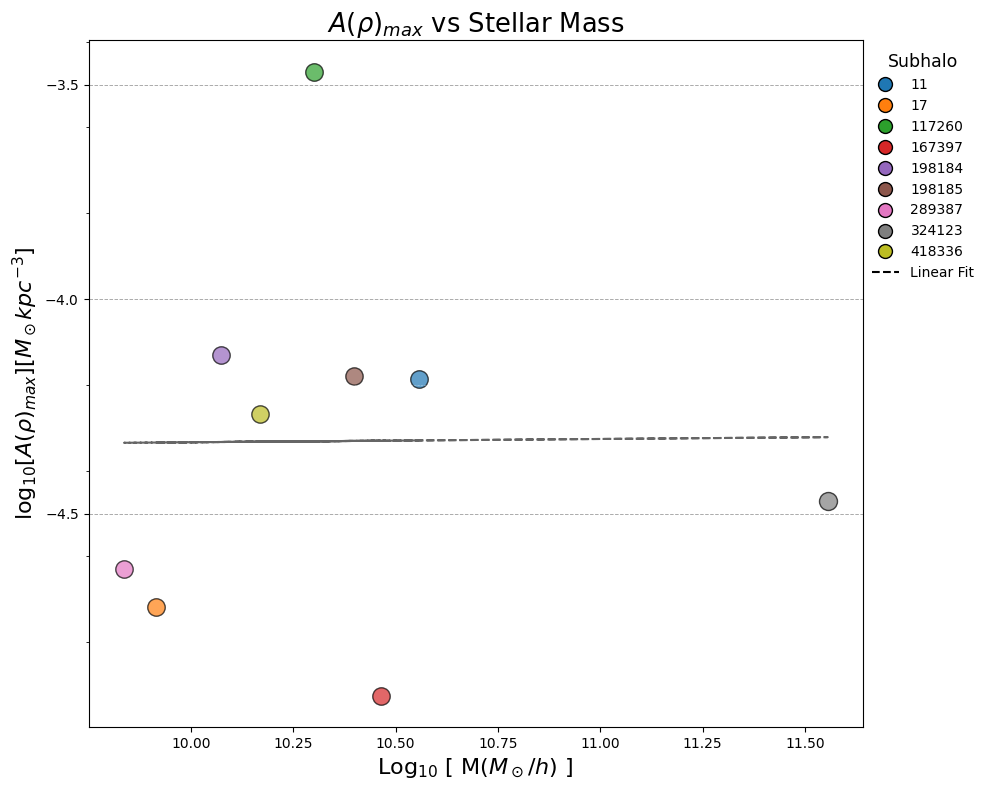

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# Calcular los promedios para cada subhalo y transformar y_max a log10
average_data = correlation_data.groupby('halo_id').mean().reset_index()
average_data['log_y_max'] = np.log10(average_data['y_max'])  # Transformar amplitud a log10

# Colores personalizados
custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
subhalo_ids = average_data['halo_id'].unique()

# Datos para el ajuste lineal (eje x: logmass0, eje y: log_y_max)
X = average_data['logmass4'].values.reshape(-1, 1)  # Masa de gas en log10
y = average_data['log_y_max'].values  # Amplitud en log10

# Crear el modelo lineal y ajustar
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Estilo predeterminado de matplotlib

# Gráfico de dispersión
for idx, row in enumerate(average_data.iterrows()):
    size = np.log10(row[1]['logmass']) * 150  # Escala de tamaño basada en logmass
    plt.scatter(row[1]['logmass4'], row[1]['log_y_max'], s=size,
                color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Graficar la línea de ajuste lineal
plt.plot(average_data['logmass4'], y_pred, color='black', linestyle='--', linewidth=1.5, alpha=0.6, label='Linear Fit')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
legend_elements.append(Line2D([0], [0], color='black', linestyle='--', label='Linear Fit'))  # Agregar línea de ajuste
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas y título
plt.title(r"$A(\rho)_{max}$ vs Stellar Mass", fontsize=18.5)
plt.xlabel(r"Log$_{10}$ [ M($M_\odot/h) $ ] ", fontsize=16)
plt.ylabel(r"$\log_{10} [A(\rho)_{max}][ M_\odot kpc^{-3} ]$", fontsize=16)

# Configuración de ticks en los ejes
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Configuración de cuadrícula y ticks en el eje y
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))

# Ajustar diseño y mostrar gráfico
plt.tight_layout()
plt.show()


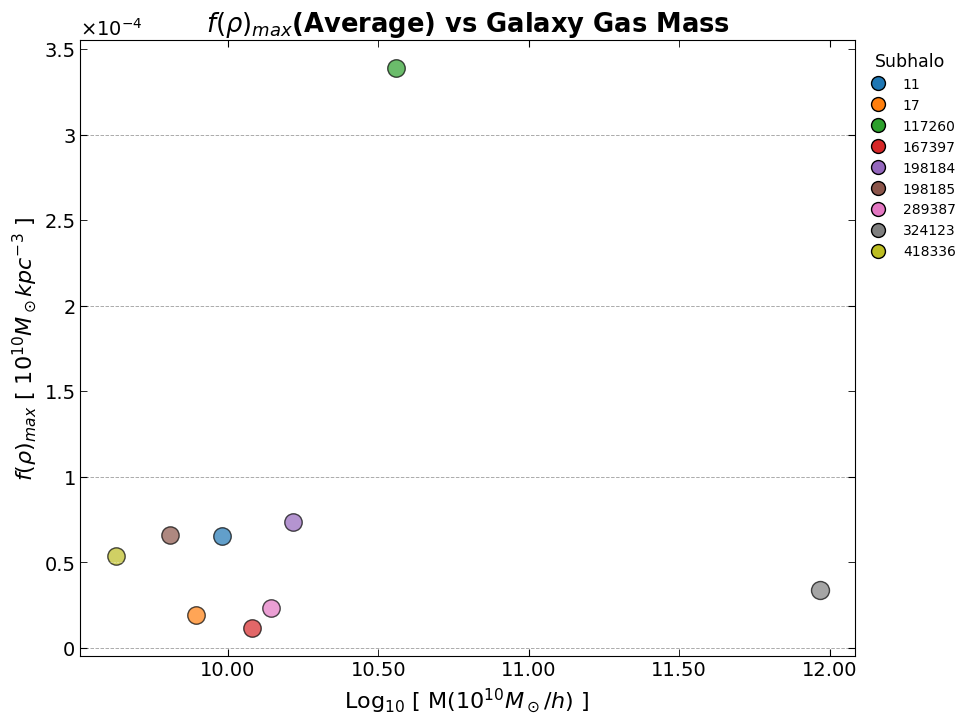

In [23]:

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Usamos el estilo predeterminado de matplotlib para simplicidad
def divide_by_minus_4(x, pos):
    return f"{x * 1e4:.1f}"  # Multiplica por 10^4 y convierte a entero

# Gráfico: Width vs Mass (solo puntos promedio)
for idx, row in enumerate(average_data.iterrows()):
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row[1]['logmass']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row[1]['logmass0'], row[1]['y_max'], s=size, color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas del gráfico y título con tamaño adecuado
plt.title(r"$f(\rho)_{max}$(Average) vs Galaxy Gas Mass", fontsize=18.5, weight='bold')
plt.xlabel(r"Log$_{10}$ [ M($10^{10} M_\odot/h) $ ] ", fontsize=16)
plt.ylabel(r"$f(\rho)_{max}$ [ $10^{10} M_\odot kpc^{-3}$ ]", fontsize=16)
#plt.xlim(10.6, 13.9)
#plt.ylim(1.01,2.78)
# Mostrar bordes y ticks en los cuatro lados
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=14, length=5)

# Configuración de ticks en los ejes x e y
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.0))       # Ticks mayores a intervalos de 1 en el eje x
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.5))     # Ticks menores a intervalos de 0.5 en el eje x
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))       # Ticks mayores a intervalos de 1 en el eje y
#plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.0001))     # Ticks menores a intervalos de 0.5 en el eje y

# Configuración de la cuadrícula en los ticks mayores e intermedios de forma independiente
# Cuadrícula en ticks mayores (11, 12, 13, ...) con un color específico
#plt.gca().xaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.78, alpha=0.78)
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)

# Cuadrícula en ticks menores (11.5, 12.5, ...) con otro color y estilo
#plt.gca().xaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.55, alpha=0.55)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)

# Asegurar que se muestren las etiquetas de los ticks menores en los ejes x e y
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

plt.gca().yaxis.set_minor_formatter(ticker.FuncFormatter(divide_by_minus_4))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

# Configuración del eje Y con notación científica
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0001))  # Ticks mayores en el eje Y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.00005))  # Ticks menores en el eje Y
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))  # Formato científico
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))  # Forzar notación científica en el eje Y
ax.yaxis.get_offset_text().set_fontsize(14)  # Ajustar tamaño de la notación científica


# Mostrar gráfico
plt.show()

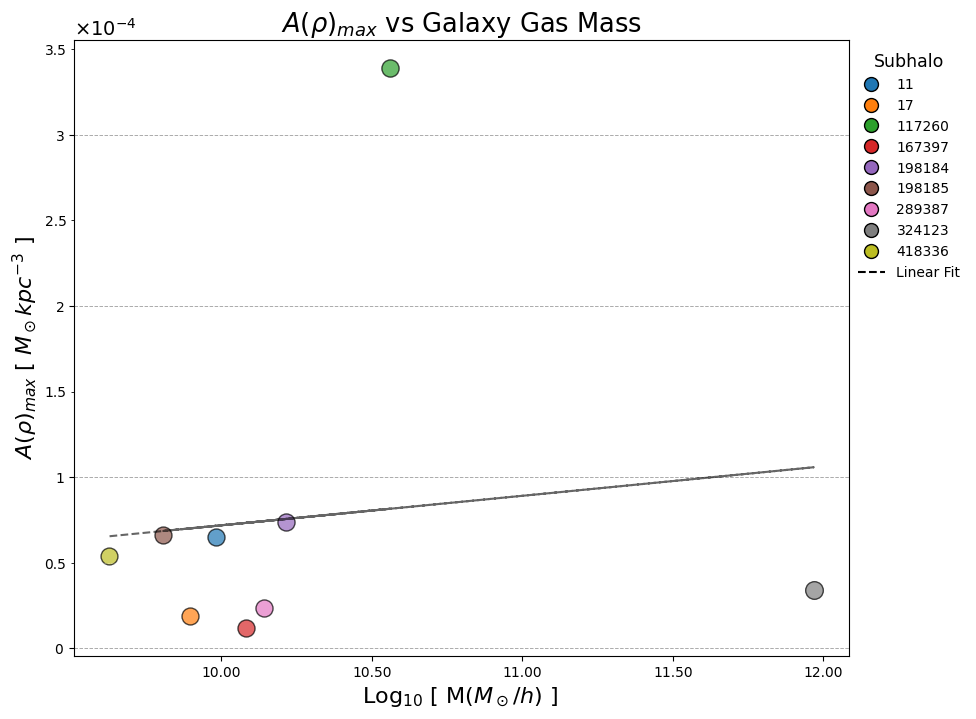

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# Extraer datos para el ajuste lineal
X = average_data['logmass0'].values.reshape(-1, 1)  # Reshape para sklearn
y = average_data['y_max'].values

# Crear el modelo lineal y ajustar
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Usamos el estilo predeterminado de matplotlib para simplicidad

def divide_by_minus_4(x, pos):
    return f"{x * 1e4:.1f}"  # Multiplica por 10^4 y convierte a decimal con 1 cifra

# Gráfico: Width vs Mass (solo puntos promedio)
for idx, row in enumerate(average_data.iterrows()):
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row[1]['logmass0']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row[1]['logmass0'], row[1]['y_max'], s=size, color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Graficar la línea de ajuste lineal
plt.plot(average_data['logmass0'], y_pred, color='black', linestyle='--', linewidth=1.5, alpha=0.6, label='Linear Fit')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
legend_elements.append(Line2D([0], [0], color='black', linestyle='--', label='Linear Fit'))  # Agregar línea de ajuste a la leyenda
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas del gráfico y título con tamaño adecuado
plt.title(r"$A(\rho)_{max}$ vs Galaxy Gas Mass", fontsize=18.5)
plt.xlabel(r"Log$_{10}$ [ M($M_\odot/h) $ ] ", fontsize=16)
plt.ylabel(r"$A(\rho)_{max}$ [ $ M_\odot kpc^{-3}$ ]", fontsize=16)

# Configuración de ticks en los ejes x e y
# Cuadrícula en ticks mayores (11, 12, 13, ...) con un color específico
#plt.gca().xaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.78, alpha=0.78)
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)

# Cuadrícula en ticks menores (11.5, 12.5, ...) con otro color y estilo
#plt.gca().xaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.55, alpha=0.55)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)

# Asegurar que se muestren las etiquetas de los ticks menores en los ejes x e y
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

plt.gca().yaxis.set_minor_formatter(ticker.FuncFormatter(divide_by_minus_4))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

# Configuración del eje Y con notación científica
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0001))  # Ticks mayores en el eje Y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.00005))  # Ticks menores en el eje Y
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))  # Formato científico
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))  # Forzar notación científica en el eje Y
ax.yaxis.get_offset_text().set_fontsize(14)  # Ajustar tamaño de la notación científica

# Mostrar gráfico
plt.show()


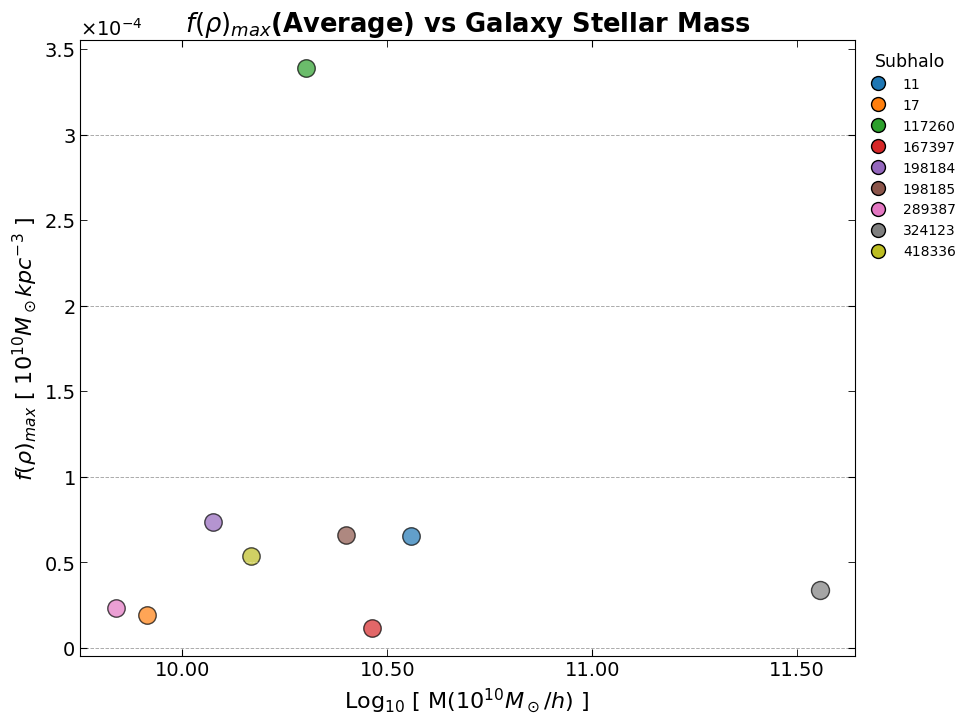

In [25]:
# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Usamos el estilo predeterminado de matplotlib para simplicidad
def divide_by_minus_4(x, pos):
    return f"{x * 1e4:.1f}"  # Multiplica por 10^4 y convierte a entero

# Gráfico: Width vs Mass (solo puntos promedio)
for idx, row in enumerate(average_data.iterrows()):
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row[1]['logmass']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row[1]['logmass4'], row[1]['y_max'], s=size, color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas del gráfico y título con tamaño adecuado
plt.title(r"$f(\rho)_{max}$(Average) vs Galaxy Stellar Mass", fontsize=18.5, weight='bold')
plt.xlabel(r"Log$_{10}$ [ M($10^{10} M_\odot/h) $ ] ", fontsize=16)
plt.ylabel(r"$f(\rho)_{max}$ [ $10^{10} M_\odot kpc^{-3}$ ]", fontsize=16)
#plt.xlim(10.6, 13.9)
#plt.ylim(1.01,2.78)
# Mostrar bordes y ticks en los cuatro lados
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=14, length=5)

# Configuración de ticks en los ejes x e y
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.0))       # Ticks mayores a intervalos de 1 en el eje x
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(0.5))     # Ticks menores a intervalos de 0.5 en el eje x
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))       # Ticks mayores a intervalos de 1 en el eje y
#plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.0001))     # Ticks menores a intervalos de 0.5 en el eje y

# Configuración de la cuadrícula en los ticks mayores e intermedios de forma independiente
# Cuadrícula en ticks mayores (11, 12, 13, ...) con un color específico
#plt.gca().xaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.78, alpha=0.78)
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)

# Cuadrícula en ticks menores (11.5, 12.5, ...) con otro color y estilo
#plt.gca().xaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.55, alpha=0.55)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)

# Asegurar que se muestren las etiquetas de los ticks menores en los ejes x e y
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

plt.gca().yaxis.set_minor_formatter(ticker.FuncFormatter(divide_by_minus_4))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

# Configuración del eje Y con notación científica
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0001))  # Ticks mayores en el eje Y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.00005))  # Ticks menores en el eje Y
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))  # Formato científico
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))  # Forzar notación científica en el eje Y
ax.yaxis.get_offset_text().set_fontsize(14)  # Ajustar tamaño de la notación científica


# Mostrar gráfico
plt.show()

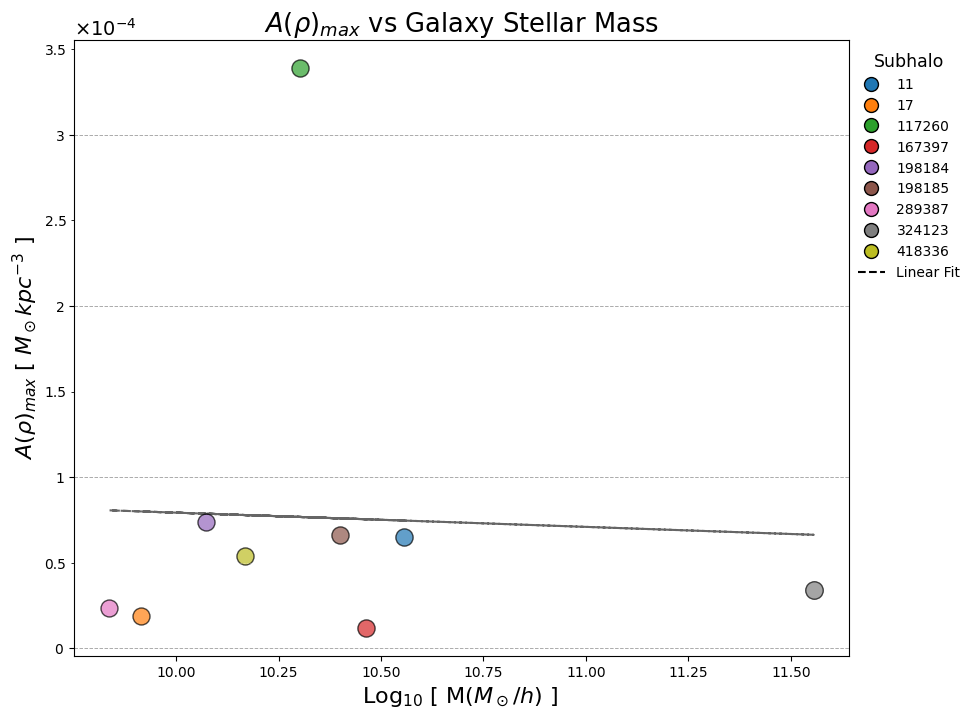

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

# Extraer datos para el ajuste lineal
X = average_data['logmass4'].values.reshape(-1, 1)  # Reshape para sklearn
y = average_data['y_max'].values

# Crear el modelo lineal y ajustar
linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred = linear_model.predict(X)

# Configuración de la figura
plt.figure(figsize=(10, 8))
plt.style.use('default')  # Usamos el estilo predeterminado de matplotlib para simplicidad

def divide_by_minus_4(x, pos):
    return f"{x * 1e4:.1f}"  # Multiplica por 10^4 y convierte a decimal con 1 cifra

# Gráfico: Width vs Mass (solo puntos promedio)
for idx, row in enumerate(average_data.iterrows()):
    # Escala de tamaño usando logmass para visualizar diferencias pequeñas
    size = np.log10(row[1]['logmass4']) * 150  # Ajuste para que las diferencias de tamaño se noten
    plt.scatter(row[1]['logmass4'], row[1]['y_max'], s=size, color=custom_colors[idx % len(custom_colors)], alpha=0.7, edgecolor='k')

# Graficar la línea de ajuste lineal
plt.plot(average_data['logmass4'], y_pred, color='black', linestyle='--', linewidth=1.5, alpha=0.6, label='Linear Fit')

# Leyenda personalizada
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"{int(subhalo_id)}", 
           markerfacecolor=custom_colors[idx % len(custom_colors)], markersize=10, markeredgecolor='k')
    for idx, subhalo_id in enumerate(subhalo_ids)
]
legend_elements.append(Line2D([0], [0], color='black', linestyle='--', label='Linear Fit'))  # Agregar línea de ajuste a la leyenda
plt.legend(handles=legend_elements, title="Subhalo", bbox_to_anchor=(0.995, 1), loc='upper left', 
           title_fontsize=12.5, fontsize=10, frameon=False)

# Etiquetas del gráfico y título con tamaño adecuado
plt.title(r"$A(\rho)_{max}$ vs Galaxy Stellar Mass", fontsize=18.5)
plt.xlabel(r"Log$_{10}$ [ M($M_\odot/h) $ ] ", fontsize=16)
plt.ylabel(r"$A(\rho)_{max}$ [ $ M_\odot kpc^{-3}$ ]", fontsize=16)

# Configuración de ticks en los ejes x e y
                           # Ajustar tamaño de la notación científica
#plt.gca().xaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.78, alpha=0.78)
plt.gca().yaxis.grid(True, which="major", color='gray', linestyle='--', linewidth=0.68, alpha=0.68)

# Cuadrícula en ticks menores (11.5, 12.5, ...) con otro color y estilo
#plt.gca().xaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.55, alpha=0.55)
plt.gca().yaxis.grid(True, which="minor", color='white', linestyle='--', linewidth=0.45, alpha=0.45)

# Asegurar que se muestren las etiquetas de los ticks menores en los ejes x e y
plt.gca().xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

plt.gca().yaxis.set_minor_formatter(ticker.FuncFormatter(divide_by_minus_4))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  

# Configuración del eje Y con notación científica
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0001))  # Ticks mayores en el eje Y
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.00005))  # Ticks menores en el eje Y
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))  # Formato científico
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))  # Forzar notación científica en el eje Y
ax.yaxis.get_offset_text().set_fontsize(14)  # Ajustar tamaño de la notación científica

# Mostrar gráfico
plt.show()
